In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import joblib
import numpy as np
from pathlib import Path

In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
0     100206          27   True    NotTwin                   56037_85858   
1     100610          27   True      NotMZ         DZ        52813_82634   
2     101006          35   True         MZ             51283_52850_81149   
3     101309          29   True    NotTwin                   52385_82248   
4     102008          24   True    NotTwin                   52018_81882   
..       ...         ...    ...        ...        ...                ...   
669   990366          22   True         MZ                   56064_85885   
670   991267          30   True    NotTwin                   51639_81503   
671   992673          33   True    NotTwin                   56143_85963   
672   993675          29   True    NotTwin                   55800_85621   
673   996782          28   True      NotMZ         DZ        51541_81405   

     Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
0        56037      85858                 NaN                 White  ...   
1        52813      82634                 NaN                 White  ...   
2        51283      81149                 NaN  Black or African Am.  ...   
3        52385      82248                 NaN  Black or African Am.  ...   
4        52018      81882                 NaN                 White  ...   
..         ...        ...                 ...                   ...  ...   
669      56064      85885                 NaN                 White  ...   
670      51639      81503                 NaN                 White  ...   
671      56143      85963                 NaN                 White  ...   
672      55800      85621                 NaN                 White  ...   
673      51541      81405                 NaN                 White  ...   

    Noise_Comp  Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0      108.79        97.19                  1.0   
1          2.0      122.25       110.45                  0.0   
2          6.0      122.25       111.41                  0.0   
3          5.2      122.25       110.45                  0.0   
4          6.0      122.25       110.45                  0.0   
..         ...         ...          ...                  ...   
669        4.4      108.79        97.19                  1.0   
670        2.8      122.25       111.41                  1.0   
671        3.6      122.25       111.41                  1.0   
672        0.4      122.25       110.45                  0.0   
673        6.0      108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 38.6       106.39        104.39            1.80        0.0   
4                 50.1        67.48         65.31            1.80        0.0   
..                 ...          ...           ...             ...        ...   
669               52.6        93.82         92.63            1.80        0.0   
670               46.6        83.23         81.55            1.84        0.0   
671               38.6       101.63         99.26            1.80        0.0   
672               38.6        84.07         84.25            1.80        1.0   
673               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.80  
..          ...  
669        1.80  
670        1.84  
671        1.80  
672        1.76  
673        1.84  

[674 rows x 583 columns]

In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

index  subject_label  Age_in_Yrs  HasGT ZygositySR ZygosityGT  \
0        0         100206          27   True    NotTwin              
1        1         100610          27   True      NotMZ         DZ   
2        2         101006          35   True         MZ              
3        4         102008          24   True    NotTwin              
4        7         102513          30   True    NotTwin              
..     ...            ...         ...    ...        ...        ...   
565    669         990366          22   True         MZ              
566    670         991267          30   True    NotTwin              
567    671         992673          33   True    NotTwin              
568    672         993675          29   True    NotTwin              
569    673         996782          28   True      NotMZ         DZ   

             Family_ID  Mother_ID  Father_ID  TestRetestInterval  ...  \
0          56037_85858      56037      85858                 NaN  ...   
1          52813_82634      52813      82634                 NaN  ...   
2    51283_52850_81149      51283      81149                 NaN  ...   
3          52018_81882      52018      81882                 NaN  ...   
4          56077_85897      56077      85897                 NaN  ...   
..                 ...        ...        ...                 ...  ...   
565        56064_85885      56064      85885                 NaN  ...   
566        51639_81503      51639      81503                 NaN  ...   
567        56143_85963      56143      85963                 NaN  ...   
568        55800_85621      55800      85621                 NaN  ...   
569        51541_81405      51541      81405                 NaN  ...   

    Noise_Comp Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0     108.79        97.19                  1.0   
1          2.0     122.25       110.45                  0.0   
2          6.0     122.25       111.41                  0.0   
3          6.0     122.25       110.45                  0.0   
4          5.2     108.79        98.04                  2.0   
..         ...        ...          ...                  ...   
565        4.4     108.79        97.19                  1.0   
566        2.8     122.25       111.41                  1.0   
567        3.6     122.25       111.41                  1.0   
568        0.4     122.25       110.45                  0.0   
569        6.0     108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 50.1        67.48         65.31            1.80        0.0   
4                 54.3        84.07         82.37            1.92        0.0   
..                 ...          ...           ...             ...        ...   
565               52.6        93.82         92.63            1.80        0.0   
566               46.6        83.23         81.55            1.84        0.0   
567               38.6       101.63         99.26            1.80        0.0   
568               38.6        84.07         84.25            1.80        1.0   
569               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.92  
..          ...  
565        1.80  
566        1.84  
567        1.80  
568        1.76  
569        1.84  

[570 rows x 584 columns]

In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [5]:
#save new csv with modifications as "final hcp database"
Final_df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [2]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

# Classification et trouver seed region qui donnent une meilleure classification

In [7]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [8]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [9]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [10]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [11]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [12]:
def run(df_boot, data, seed):
    df_bootstrap = pd.DataFrame()
    for j in range(0, len(df_boot)):
        index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)


    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_bootstrap)
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning(x_correl, y_sex)

    return x_correl

In [13]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    X_std = x_correl.std()
    weighted_coef = moyenne * X_std                        #REPETITION ICI ^??
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [14]:
def bestRegion(ROIs):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(Final_df["Gender"])):
        if Final_df["Gender"][i] == 0:
            label_male.append(Final_df["subject_label"][i])

        elif Final_df["Gender"][i] == 1:
            label_female.append(Final_df["subject_label"][i])
            

    for i in data.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("male std : "+str(np.std(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        print("female std : "+str(np.std(best_roi[i][3])))
        table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

## Single run with all seed

In [15]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [16]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

100%|█████████████████████████████████████████| 570/570 [01:39<00:00,  5.72it/s]


In [17]:
run_1 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 572772.71it/s]

train: 456 test: 114


[array([0.95652174, 1.        , 0.86956522, 0.91304348, 1.        ,
       0.91304348, 0.95652174, 1.        , 0.86956522, 0.95652174,
       1.        , 0.95652174, 0.91304348, 0.91304348, 0.95652174,
       0.95652174, 0.90909091, 0.90909091, 0.95454545, 0.86363636])]
predicted class  Femme  Homme
actual class                 
Femme               53      9
Homme                9     43
accuracy test (r2) = 0.8421052631578947
accuracy train (r2) = 1.0


In [18]:
run_cv10 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 476625.45it/s]


train: 456 test: 114
[array([0.95652174, 1.        , 0.95652174, 0.91304348, 0.95652174,
       0.91304348, 0.91304348, 0.86956522, 0.73913043, 0.91304348,
       0.91304348, 0.91304348, 0.86956522, 0.91304348, 0.95652174,
       0.91304348, 1.        , 1.        , 0.90909091, 0.95454545])]
predicted class  Femme  Homme
actual class                 
Femme               56      5
Homme                2     51
accuracy test (r2) = 0.9385964912280702
accuracy train (r2) = 1.0


## Bootstrap result all seed, single seed, all left seed and all right seed

In [18]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-all_mean_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_L_mean_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_R_mean_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_L_mean_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_R_mean_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_L_mean_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_R_mean_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_L_mean_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_R_mean_LinearSVC.pkl"
results_path_all_left = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-left_mean_LinearSVC.pkl"
results_path_all_right = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-right_mean_LinearSVC.pkl"



results = joblib.load(results_path_all_seed)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
moyenne.shape

(1184,)

In [19]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

# Dataframe for violinplot

In [2]:
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})
df

NameError: name 'data' is not defined

In [155]:
df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]
df_connectivity

participant_id     seed Gender                     name     value  \
0               100206  opIFG_L    men   L G_and_S_frontomargin -0.004726   
1               100610  opIFG_L    men   L G_and_S_frontomargin  0.019454   
2               101006  opIFG_L  women   L G_and_S_frontomargin -0.008363   
3               102008  opIFG_L    men   L G_and_S_frontomargin  0.081125   
4               102513  opIFG_L    men   L G_and_S_frontomargin  0.015992   
...                ...      ...    ...                      ...       ...   
674875          990366   pITG_R    men  R S_temporal_transverse  0.128093   
674876          991267   pITG_R    men  R S_temporal_transverse  0.102424   
674877          992673   pITG_R  women  R S_temporal_transverse  0.131250   
674878          993675   pITG_R  women  R S_temporal_transverse  0.059007   
674879          996782   pITG_R  women  R S_temporal_transverse  0.152758   

                                       pair  
0       opIFG_L with L G_and_S_frontomargin  
1       opIFG_L with L G_and_S_frontomargin  
2       opIFG_L with L G_and_S_frontomargin  
3       opIFG_L with L G_and_S_frontomargin  
4       opIFG_L with L G_and_S_frontomargin  
...                                     ...  
674875  pITG_R with R S_temporal_transverse  
674876  pITG_R with R S_temporal_transverse  
674877  pITG_R with R S_temporal_transverse  
674878  pITG_R with R S_temporal_transverse  
674879  pITG_R with R S_temporal_transverse  

[674880 rows x 6 columns]

[Text(0, 0, 'aMTG_L +\n Destrieux 43'), Text(1, 0, 'Top 2')]

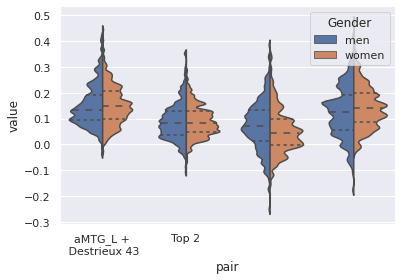

In [165]:
# list to make sure top 10 regions are in order 

top10 = ["aMTG_L with L S_front_sup", "aMTG_L with R G_pariet_inf-Angular", "pITG_L with R G_front_inf-Orbital", "aMTG_L with L G_and_S_transv_frontopol", "planumtemp_R with L S_interm_prim-Jensen", "

df_temp = df_connectivity.loc[
    #(df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(["aMTG_L with L S_front_sup", "aMTG_L with R G_pariet_inf-Angular", "pITG_L with R G_front_inf-Orbital", "aMTG_L with L G_and_S_transv_frontopol"]))
]  # entrer manuellement les top 10 meilleurs seed labels pairs 

v_plot = sns.violinplot(x="pair", y="value", hue="Gender", data=df_temp, split=True, bw=.10,inner= "quartile")
v_plot.set_xticks([0,1])
v_plot.set_xticklabels(["aMTG_L +\n Destrieux 43", "Top 2"])

## Best regions for all seeds

      coefficient          seed                      labels
349      0.065065        aMTG_L               L S_front_sup
394      0.064704        aMTG_L      R G_pariet_inf-Angular
530      0.059958        pITG_L       R G_front_inf-Orbital
300      0.058810        aMTG_L  L G_and_S_transv_frontopol
794      0.057812  planumtemp_R      L S_interm_prim-Jensen
1056     0.057356        pITG_R     L G_oc-temp_lat-fusifor
453      0.056008        pITG_L     L G_cingul-Post-ventral
41       0.054990       opIFG_L            L Pole_occipital
783      0.054225  planumtemp_R               L S_calcarine
941      0.050072        aMTG_R               L S_front_sup
The mean accuracy : 0.916316814159292
The standard deviation of the accuracy : 0.027862591976324208
The lower boundry of the confidance interval of the accuracy : 0.8617061338856966
The upper boundry of the confidance interval of the accuracy : 0.9709274944328874


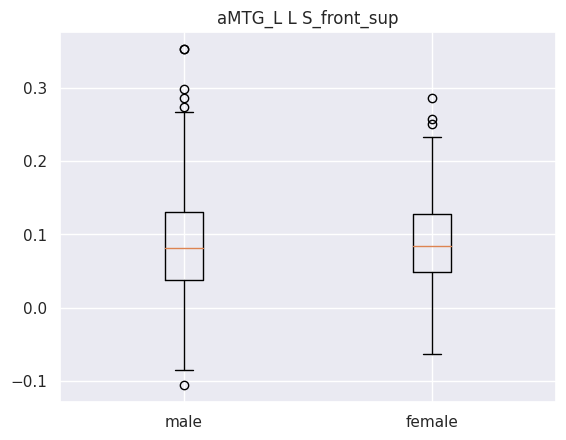

Ttest_indResult(statistic=-0.16306014953081052, pvalue=0.8705290727591274)
male mean : 0.08941226
male std : 0.07188258
female mean : 0.09030944
female std : 0.05921447


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


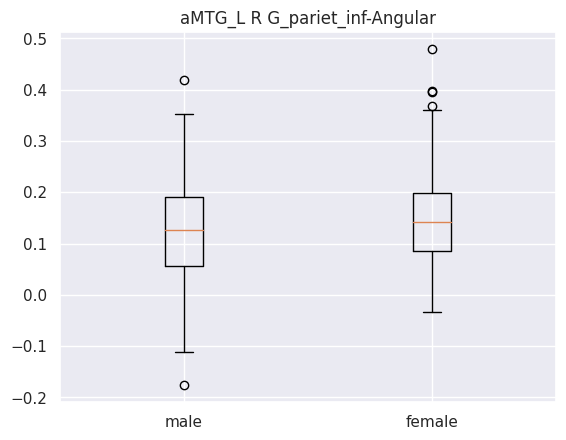

Ttest_indResult(statistic=-2.9146205507484293, pvalue=0.0037015702185267565)
male mean : 0.12457278
male std : 0.09838336
female mean : 0.1470128
female std : 0.08510771


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


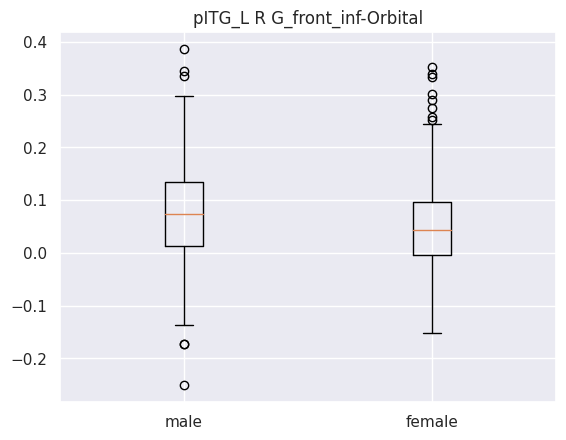

Ttest_indResult(statistic=2.720946268405945, pvalue=0.006709080997868932)
male mean : 0.07330693
male std : 0.09566736
female mean : 0.052528843
female std : 0.08628308


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


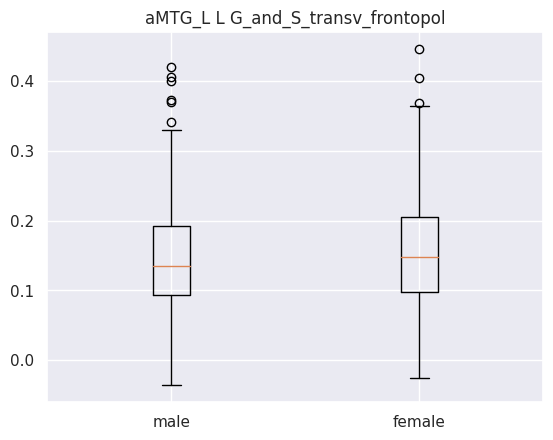

Ttest_indResult(statistic=-0.4347863513193104, pvalue=0.6638826490308001)
male mean : 0.15048955
male std : 0.07943841
female mean : 0.15334298
female std : 0.07672297


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


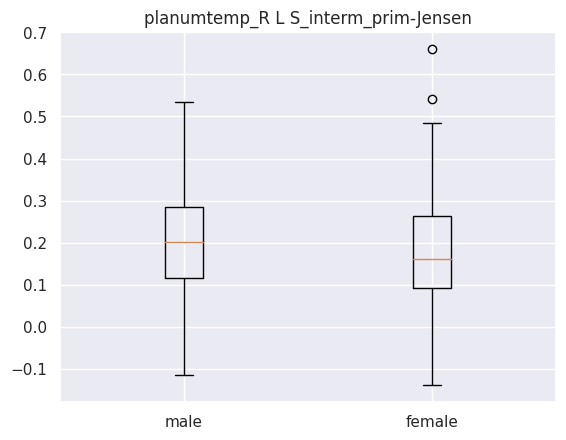

Ttest_indResult(statistic=2.6529671797713563, pvalue=0.008201963275399593)
male mean : 0.20600034
male std : 0.12871465
female mean : 0.17834951
female std : 0.11951731


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


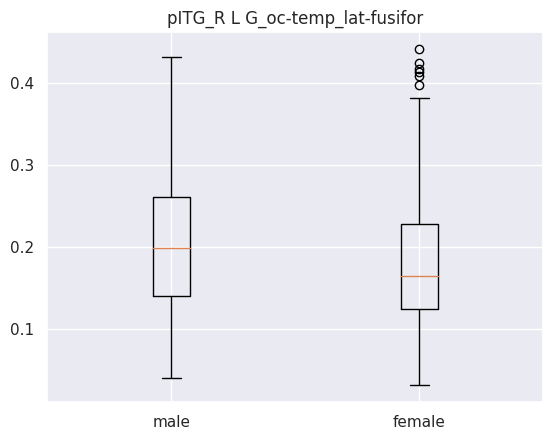

Ttest_indResult(statistic=3.277484422127677, pvalue=0.0011113280120916263)
male mean : 0.20170005
male std : 0.08080574
female mean : 0.17975447
female std : 0.07849484


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


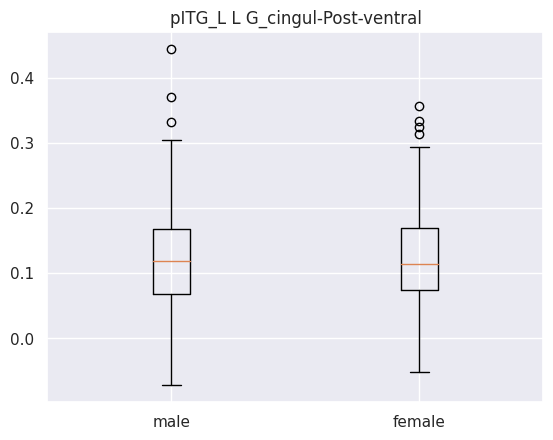

Ttest_indResult(statistic=0.003224637189575209, pvalue=0.9974282484204979)
male mean : 0.121866316
male std : 0.07354929
female mean : 0.121846415
female std : 0.07316029


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


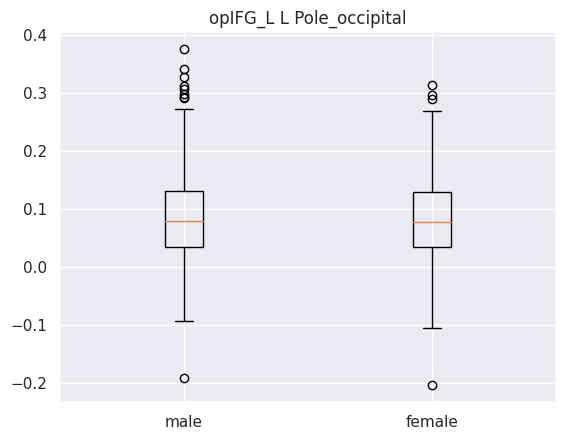

Ttest_indResult(statistic=1.022701558623377, pvalue=0.3068843423684203)
male mean : 0.08923399
male std : 0.08501718
female mean : 0.08254886
female std : 0.070746034


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


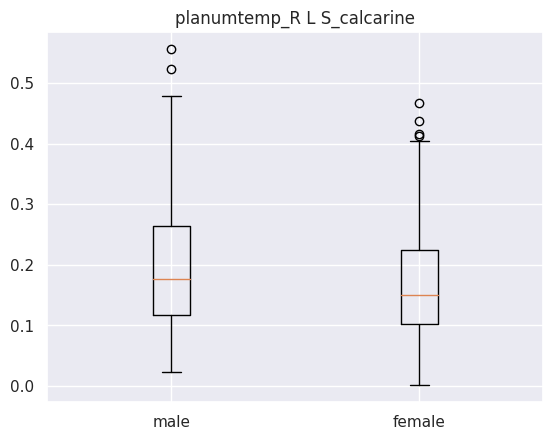

Ttest_indResult(statistic=3.1724387476981906, pvalue=0.0015932968935781927)
male mean : 0.19657883
male std : 0.10440613
female mean : 0.1700965
female std : 0.09448411


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


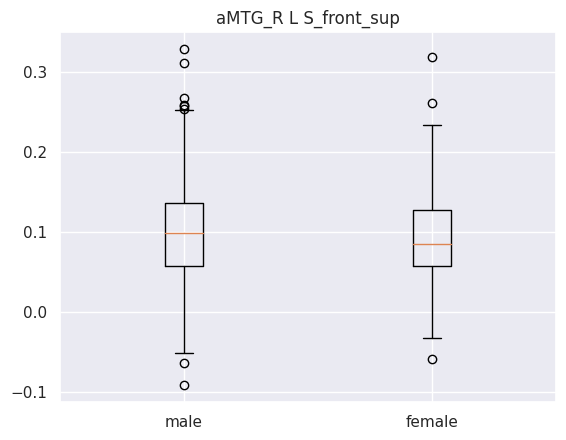

Ttest_indResult(statistic=1.3124198838062673, pvalue=0.18990857956645163)
male mean : 0.09976947
male std : 0.067789316
female mean : 0.0929379
female std : 0.056244437
                                  Region       Men     Women   P value
0                 aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1        aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2         pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
3    aMTG_L - L G_and_S_transv_frontopol  0.150490  0.153343  0.663883
4  planumtemp_R - L S_interm_prim-Jensen  0.206000  0.178350  0.008202
5       pITG_R - L G_oc-temp_lat-fusifor  0.201700  0.179754  0.001111
6       pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
7             opIFG_L - L Pole_occipital  0.089234  0.082549  0.306884
8           planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
9                 aMTG_R - L S_front_sup  0.099769  0.092938  0.189909


/tmp/ipykernel_772313/2138281483.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [27]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_L

     coefficient    seed                       labels
53      0.174186  aMTG_L                L S_front_sup
98      0.148002  aMTG_L       R G_pariet_inf-Angular
4       0.143294  aMTG_L   L G_and_S_transv_frontopol
78      0.118132  aMTG_L   R G_and_S_transv_frontopol
64      0.117041  aMTG_L        L S_parieto_occipital
104     0.110713  aMTG_L                   R G_rectus
55      0.107197  aMTG_L  L S_intrapariet_and_P_trans
103     0.106396  aMTG_L                R G_precuneus
135     0.103946  aMTG_L          R S_orbital_lateral
87      0.103900  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.7934628318584072
The standard deviation of the accuracy : 0.0388570983771416
The lower boundry of the confidance interval of the accuracy : 0.7173029190392096
The upper boundry of the confidance interval of the accuracy : 0.8696227446776047


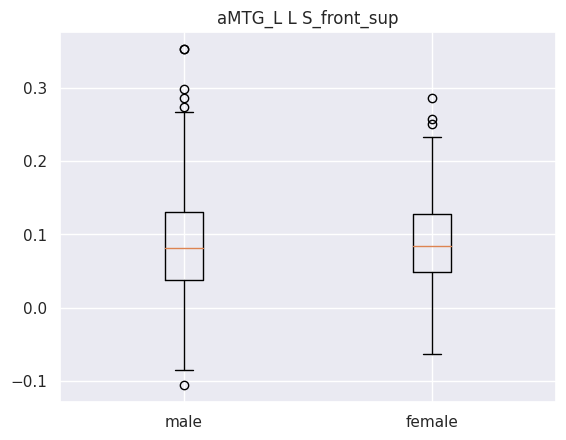

Ttest_indResult(statistic=-0.16306014953081052, pvalue=0.8705290727591274)
male mean : 0.08941226
male std : 0.07188258
female mean : 0.09030944
female std : 0.05921447


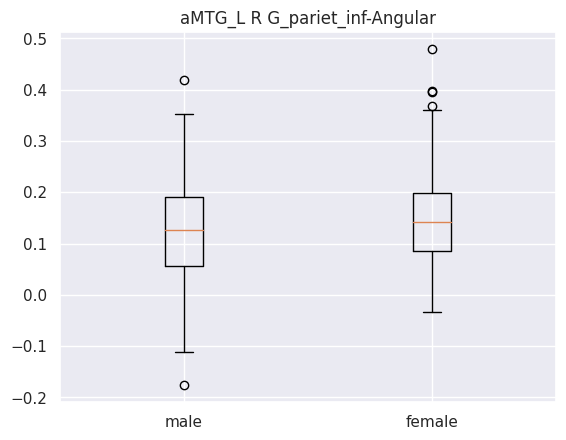

Ttest_indResult(statistic=-2.9146205507484293, pvalue=0.0037015702185267565)
male mean : 0.12457278
male std : 0.09838336
female mean : 0.1470128
female std : 0.08510771


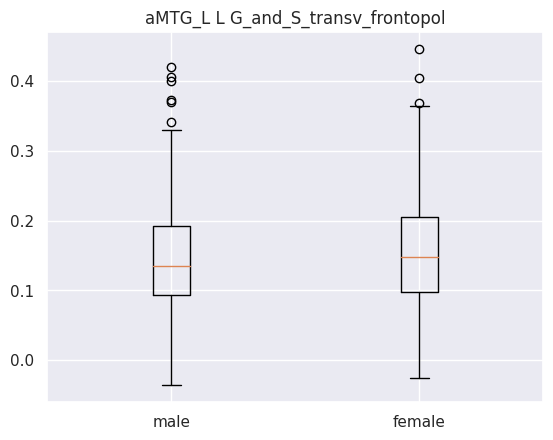

Ttest_indResult(statistic=-0.4347863513193104, pvalue=0.6638826490308001)
male mean : 0.15048955
male std : 0.07943841
female mean : 0.15334298
female std : 0.07672297


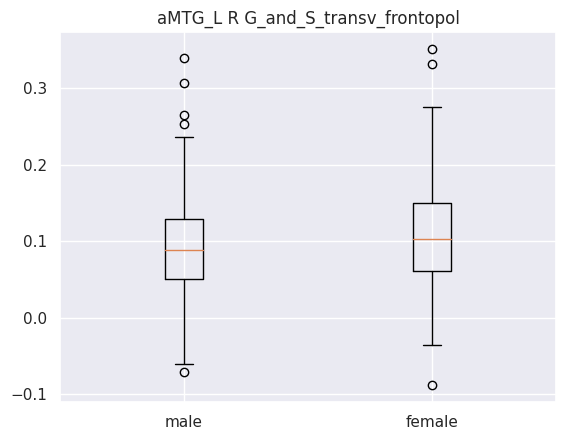

Ttest_indResult(statistic=-2.5711486243649295, pvalue=0.010389551497346777)
male mean : 0.09560566
male std : 0.06308813
female mean : 0.10965275
female std : 0.06647152


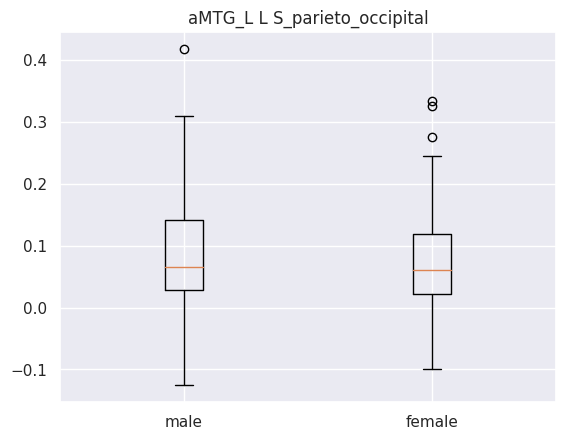

Ttest_indResult(statistic=2.4364778495962423, pvalue=0.01513723310479231)
male mean : 0.08481123
male std : 0.08180212
female mean : 0.06949203
female std : 0.06801959


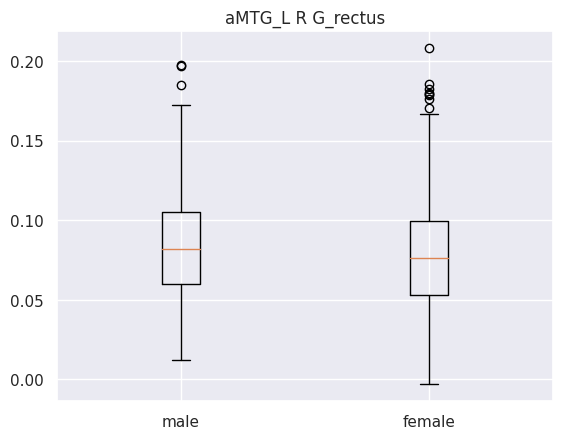

Ttest_indResult(statistic=1.7718693905054808, pvalue=0.07695230100546788)
male mean : 0.08437557
male std : 0.034266844
female mean : 0.0790933
female std : 0.036400635


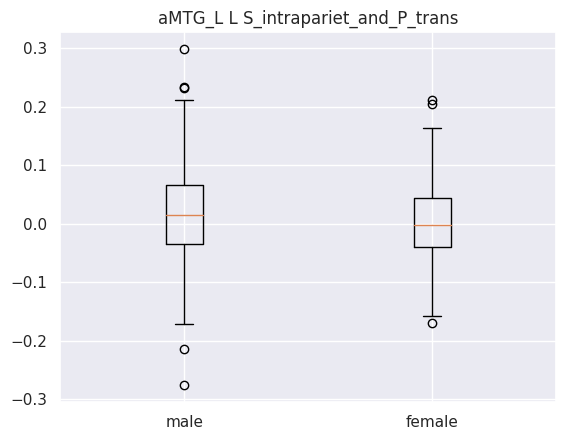

Ttest_indResult(statistic=1.5534617384302924, pvalue=0.12086984693044656)
male mean : 0.014690557
male std : 0.07998747
female mean : 0.005323266
female std : 0.06360493


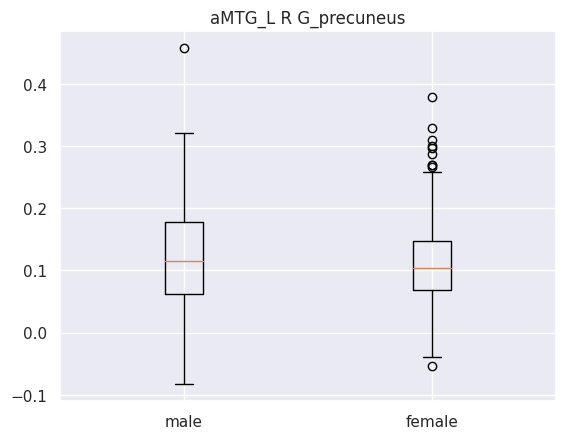

Ttest_indResult(statistic=1.3281167062375776, pvalue=0.1846729724626372)
male mean : 0.11954241
male std : 0.08017354
female mean : 0.1113971
female std : 0.06595112


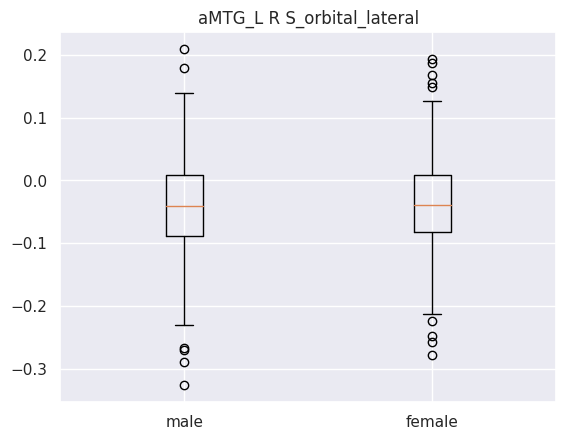

Ttest_indResult(statistic=-1.2924658401410072, pvalue=0.19672140014569844)
male mean : -0.042981237
male std : 0.07802688
female mean : -0.034570992
female std : 0.07672487


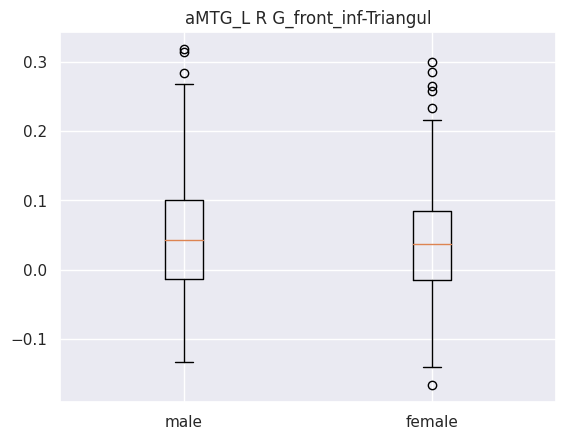

Ttest_indResult(statistic=1.1987429311947804, pvalue=0.23112780121299095)
male mean : 0.04718627
male std : 0.086391665
female mean : 0.03892026
female std : 0.07790845
                                 Region       Men     Women   P value
0                aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1       aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2   aMTG_L - L G_and_S_transv_frontopol  0.150490  0.153343  0.663883
3   aMTG_L - R G_and_S_transv_frontopol  0.095606  0.109653  0.010390
4        aMTG_L - L S_parieto_occipital  0.084811  0.069492  0.015137
5                   aMTG_L - R G_rectus  0.084376  0.079093  0.076952
6  aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323  0.120870
7                aMTG_L - R G_precuneus  0.119542  0.111397  0.184673
8          aMTG_L - R S_orbital_lateral -0.042981 -0.034571  0.196721
9       aMTG_L - R G_front_inf-Triangul  0.047186  0.038920  0.231128


In [34]:
rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_R

     coefficient    seed                      labels
53      0.143630  aMTG_R               L S_front_sup
4       0.133417  aMTG_R  L G_and_S_transv_frontopol
78      0.128948  aMTG_R  R G_and_S_transv_frontopol
90      0.125441  aMTG_R   R G_Ins_lg_and_S_cent_ins
135     0.123918  aMTG_R         R S_orbital_lateral
104     0.113448  aMTG_R                  R G_rectus
66      0.111854  aMTG_R             L S_postcentral
22      0.110805  aMTG_R     L G_oc-temp_med-Parahip
98      0.107523  aMTG_R      R G_pariet_inf-Angular
99      0.105601  aMTG_R     R G_pariet_inf-Supramar
The mean accuracy : 0.7966398230088495
The standard deviation of the accuracy : 0.03879528120382583
The lower boundry of the confidance interval of the accuracy : 0.7206010718493508
The upper boundry of the confidance interval of the accuracy : 0.8726785741683482


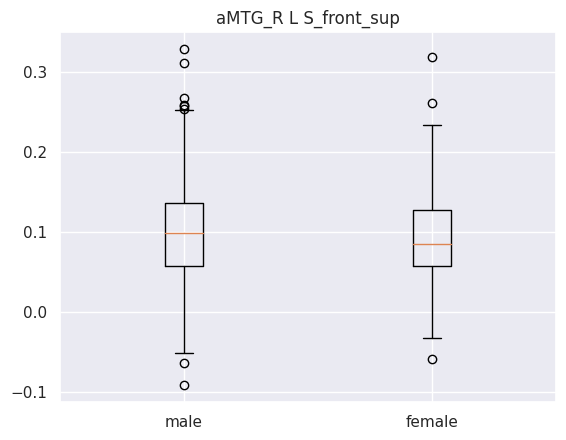

Ttest_indResult(statistic=1.3124198838062673, pvalue=0.18990857956645163)
male mean : 0.09976947
male std : 0.067789316
female mean : 0.0929379
female std : 0.056244437


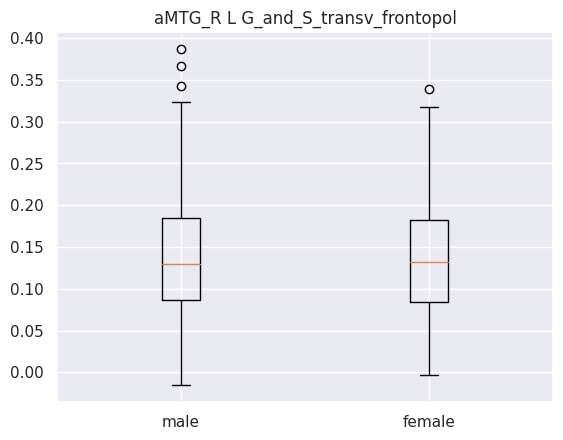

Ttest_indResult(statistic=0.6162901573548603, pvalue=0.5379499383607076)
male mean : 0.14077756
male std : 0.07301095
female mean : 0.13714556
female std : 0.06736406


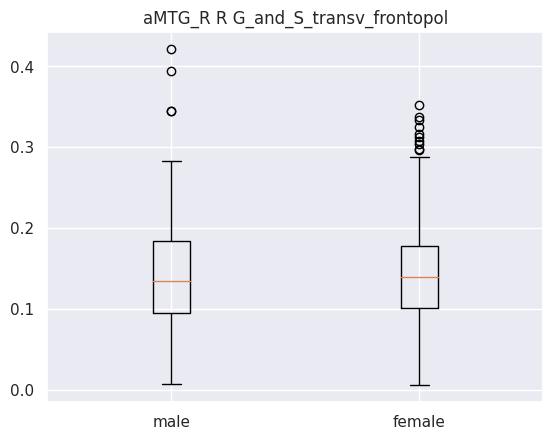

Ttest_indResult(statistic=-0.5021313672658224, pvalue=0.6157697117539259)
male mean : 0.14287779
male std : 0.06764471
female mean : 0.14569084
female std : 0.065641545


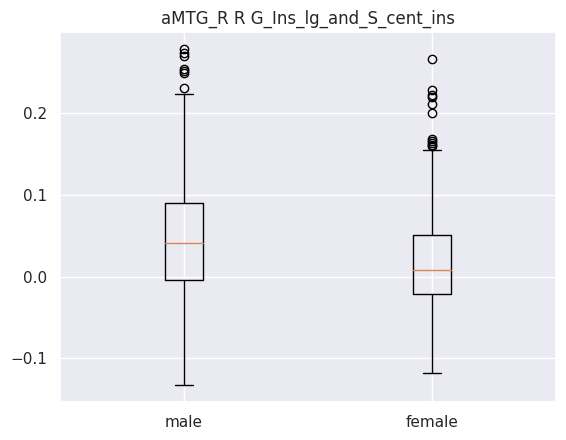

Ttest_indResult(statistic=5.221764113681091, pvalue=2.4905163561535363e-07)
male mean : 0.048215896
male std : 0.07364218
female mean : 0.018546933
female std : 0.061756957


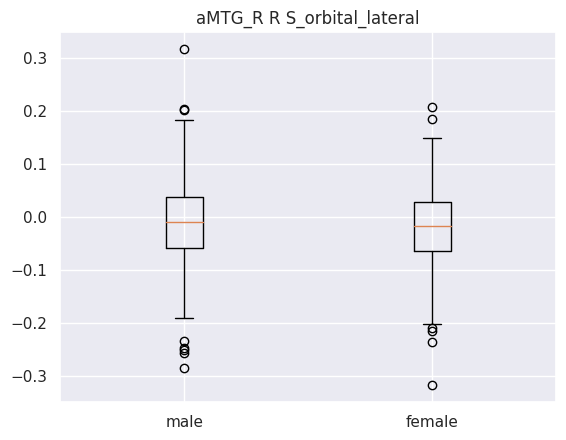

Ttest_indResult(statistic=0.8920637250991912, pvalue=0.37273652594724915)
male mean : -0.010003094
male std : 0.08398575
female mean : -0.016048837
female std : 0.07744561


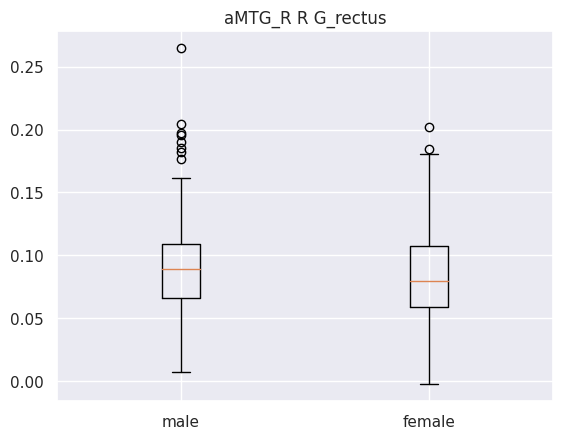

Ttest_indResult(statistic=1.9274704855247549, pvalue=0.05441935655162441)
male mean : 0.090095855
male std : 0.037141956
female mean : 0.08406715
female std : 0.037195083


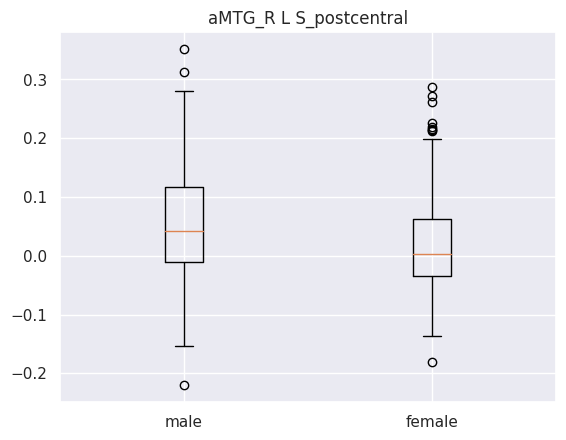

Ttest_indResult(statistic=4.322259742758993, pvalue=1.823637890874204e-05)
male mean : 0.04981075
male std : 0.09413898
female mean : 0.01834556
female std : 0.07934699


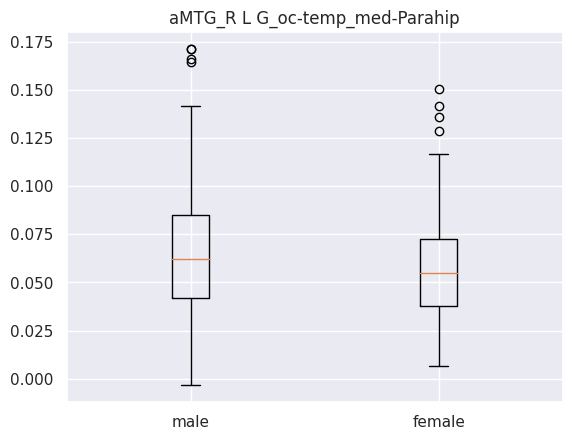

Ttest_indResult(statistic=3.2834707103545435, pvalue=0.0010884266469141023)
male mean : 0.06574333
male std : 0.030762257
female mean : 0.057849534
female std : 0.02653407


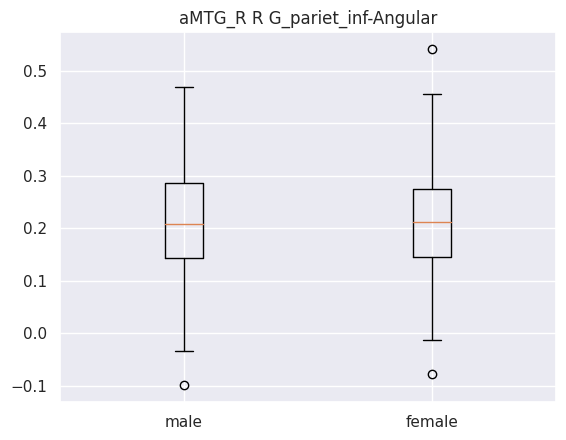

Ttest_indResult(statistic=0.3243155471346405, pvalue=0.7458185461630613)
male mean : 0.21665388
male std : 0.10249302
female mean : 0.21397533
female std : 0.09424459


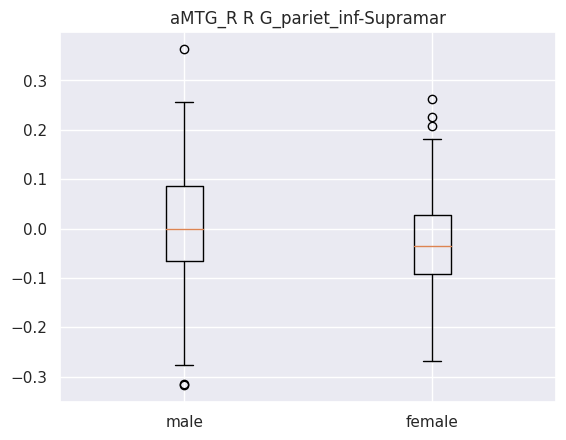

Ttest_indResult(statistic=3.8712275228698245, pvalue=0.00012086636015851661)
male mean : 0.004401155
male std : 0.11173278
female mean : -0.028612275
female std : 0.091440395
                                Region       Men     Women       P value
0               aMTG_R - L S_front_sup  0.099769  0.092938  1.899086e-01
1  aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146  5.379499e-01
2  aMTG_R - R G_and_S_transv_frontopol  0.142878  0.145691  6.157697e-01
3   aMTG_R - R G_Ins_lg_and_S_cent_ins  0.048216  0.018547  2.490516e-07
4         aMTG_R - R S_orbital_lateral -0.010003 -0.016049  3.727365e-01
5                  aMTG_R - R G_rectus  0.090096  0.084067  5.441936e-02
6             aMTG_R - L S_postcentral  0.049811  0.018346  1.823638e-05
7     aMTG_R - L G_oc-temp_med-Parahip  0.065743  0.057850  1.088427e-03
8      aMTG_R - R G_pariet_inf-Angular  0.216654  0.213975  7.458185e-01
9     aMTG_R - R G_pariet_inf-Supramar  0.004401 -0.028612  1.208664e-04


In [36]:
rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_L

     coefficient     seed                       labels
20      0.172809  opIFG_L      L G_oc-temp_lat-fusifor
47      0.124508  opIFG_L      L S_circular_insula_inf
72      0.118854  opIFG_L             L S_temporal_sup
40      0.118366  opIFG_L               L Lat_Fis-post
60      0.116207  opIFG_L  L S_oc-temp_med_and_Lingual
89      0.111760  opIFG_L                R G_front_sup
91      0.101102  opIFG_L            R G_insular_short
15      0.100868  opIFG_L                L G_front_sup
144     0.095571  opIFG_L              R S_subparietal
125     0.092673  opIFG_L                R S_front_inf
The mean accuracy : 0.8263690265486726
The standard deviation of the accuracy : 0.03637730928834068
The lower boundry of the confidance interval of the accuracy : 0.7550695003435248
The upper boundry of the confidance interval of the accuracy : 0.8976685527538204


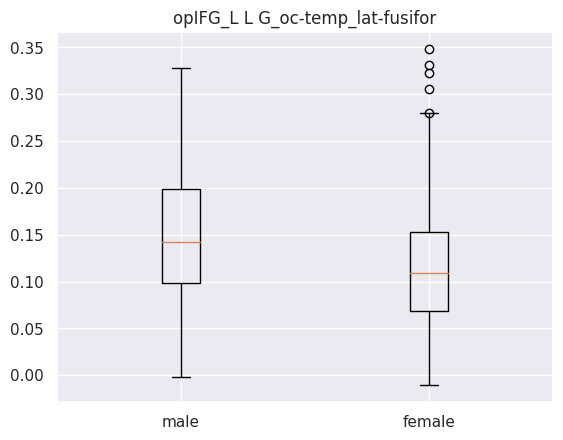

Ttest_indResult(statistic=5.8491199301815255, pvalue=8.347795842722884e-09)
male mean : 0.14884304
male std : 0.0680675
female mean : 0.116547726
female std : 0.06342522


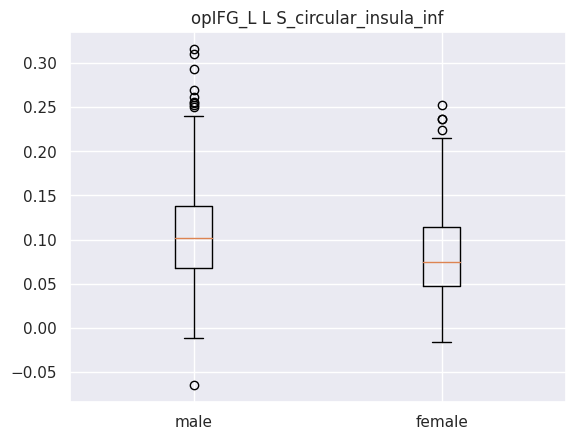

Ttest_indResult(statistic=5.852005895780225, pvalue=8.212297287985024e-09)
male mean : 0.10906584
male std : 0.058432996
female mean : 0.08297677
female std : 0.04777891


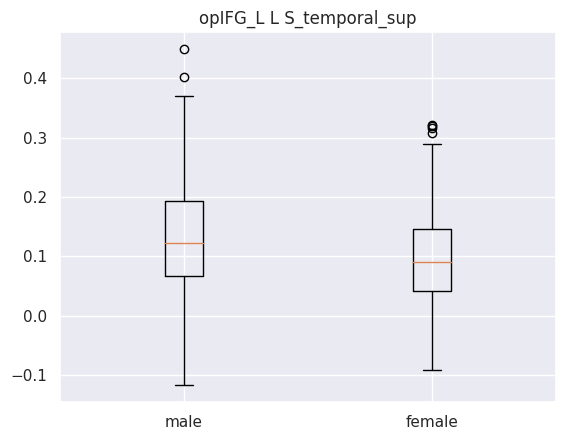

Ttest_indResult(statistic=5.019154224600444, pvalue=6.954734014816412e-07)
male mean : 0.13418752
male std : 0.09476652
female mean : 0.09735045
female std : 0.080140464


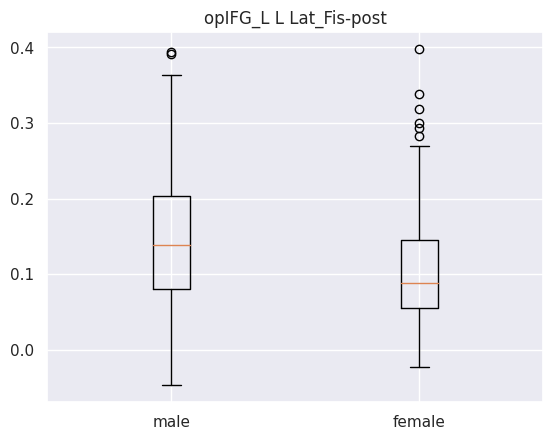

Ttest_indResult(statistic=6.364933498026034, pvalue=4.0293285082452536e-10)
male mean : 0.14507884
male std : 0.08145975
female mean : 0.104537904
female std : 0.07034103


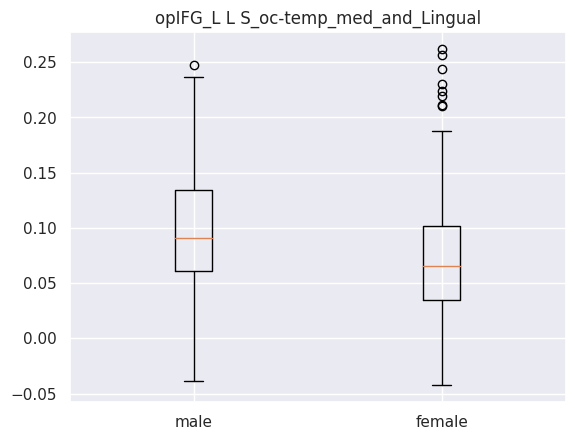

Ttest_indResult(statistic=5.761648728984817, pvalue=1.3664459018897146e-08)
male mean : 0.099059284
male std : 0.054916494
female mean : 0.073048
female std : 0.05253451


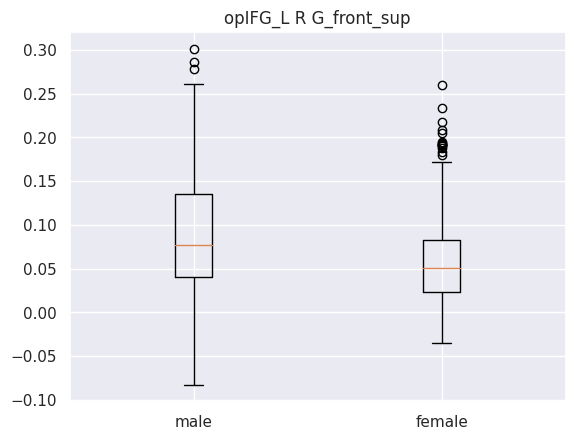

Ttest_indResult(statistic=5.707568550346583, pvalue=1.8474061471055013e-08)
male mean : 0.09004138
male std : 0.07082438
female mean : 0.060023844
female std : 0.05430409


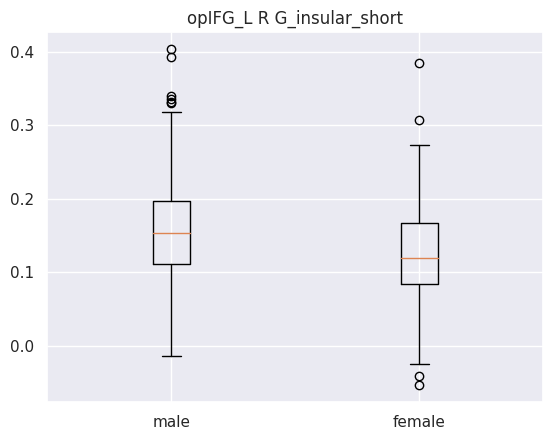

Ttest_indResult(statistic=6.392458520565345, pvalue=3.4073162063788917e-10)
male mean : 0.16011919
male std : 0.06820786
female mean : 0.12473471
female std : 0.06361477


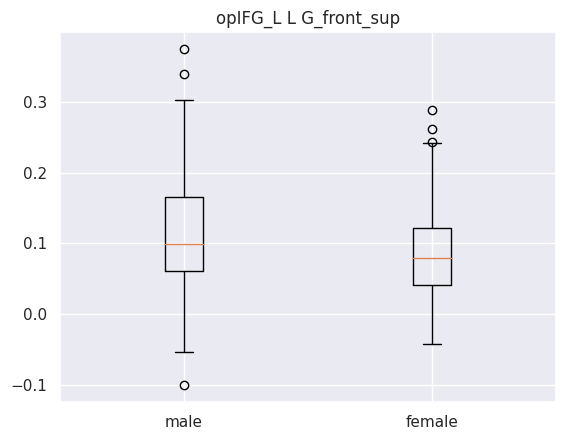

Ttest_indResult(statistic=4.949296280849985, pvalue=9.830593284072247e-07)
male mean : 0.114358306
male std : 0.07742566
female mean : 0.08558884
female std : 0.060967997


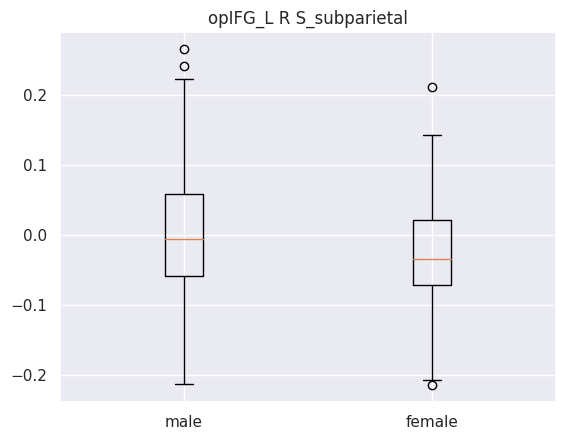

Ttest_indResult(statistic=4.51212448736246, pvalue=7.803845342034263e-06)
male mean : 0.0030093843
male std : 0.09126616
female mean : -0.026990896
female std : 0.06665871


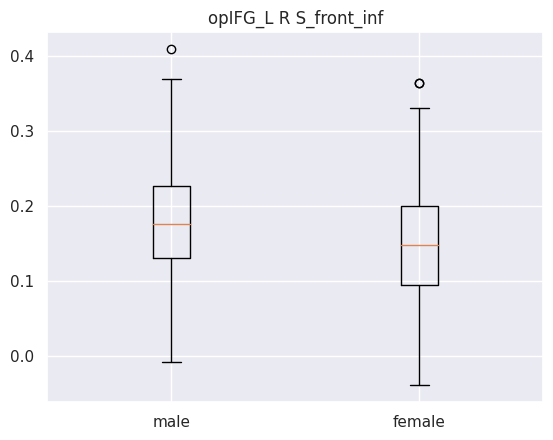

Ttest_indResult(statistic=5.63889774754518, pvalue=2.7000661897891412e-08)
male mean : 0.18022624
male std : 0.07115765
female mean : 0.14647487
female std : 0.07110807
                                  Region       Men     Women       P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.148843  0.116548  8.347796e-09
1      opIFG_L - L S_circular_insula_inf  0.109066  0.082977  8.212297e-09
2             opIFG_L - L S_temporal_sup  0.134188  0.097350  6.954734e-07
3               opIFG_L - L Lat_Fis-post  0.145079  0.104538  4.029329e-10
4  opIFG_L - L S_oc-temp_med_and_Lingual  0.099059  0.073048  1.366446e-08
5                opIFG_L - R G_front_sup  0.090041  0.060024  1.847406e-08
6            opIFG_L - R G_insular_short  0.160119  0.124735  3.407316e-10
7                opIFG_L - L G_front_sup  0.114358  0.085589  9.830593e-07
8              opIFG_L - R S_subparietal  0.003009 -0.026991  7.803845e-06
9                opIFG_L - R S_front_inf  0.180226  0.146475  2.700066e-08


In [38]:
rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_R

     coefficient     seed                       labels
121     0.160430  opIFG_R      R S_circular_insula_inf
20      0.155585  opIFG_R      L G_oc-temp_lat-fusifor
47      0.143292  opIFG_R      L S_circular_insula_inf
125     0.138920  opIFG_R                R S_front_inf
90      0.138281  opIFG_R    R G_Ins_lg_and_S_cent_ins
60      0.137888  opIFG_R  L S_oc-temp_med_and_Lingual
41      0.116023  opIFG_R             L Pole_occipital
91      0.114687  opIFG_R            R G_insular_short
80      0.112046  opIFG_R     R G_and_S_cingul-Mid-Ant
144     0.109946  opIFG_R              R S_subparietal
The mean accuracy : 0.8182610619469025
The standard deviation of the accuracy : 0.03808114602208953
The lower boundry of the confidance interval of the accuracy : 0.7436220157436071
The upper boundry of the confidance interval of the accuracy : 0.8929001081501979


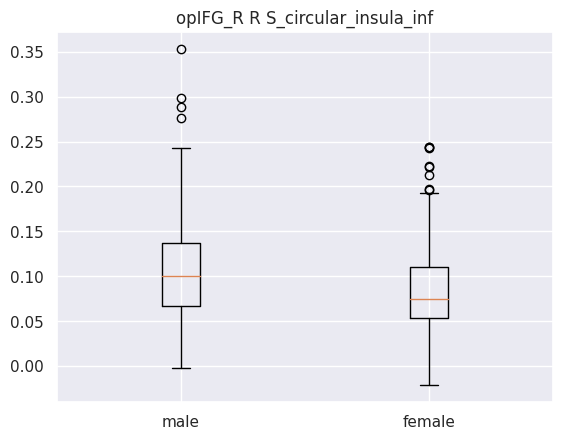

Ttest_indResult(statistic=5.226548046841275, pvalue=2.4298444756239394e-07)
male mean : 0.10671159
male std : 0.055739556
female mean : 0.08417532
female std : 0.04701804


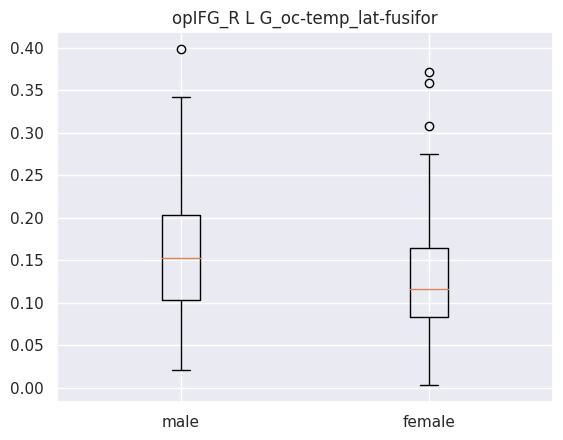

Ttest_indResult(statistic=5.7323768357456055, pvalue=1.6092027255897036e-08)
male mean : 0.1562101
male std : 0.06858041
female mean : 0.12528288
female std : 0.059998482


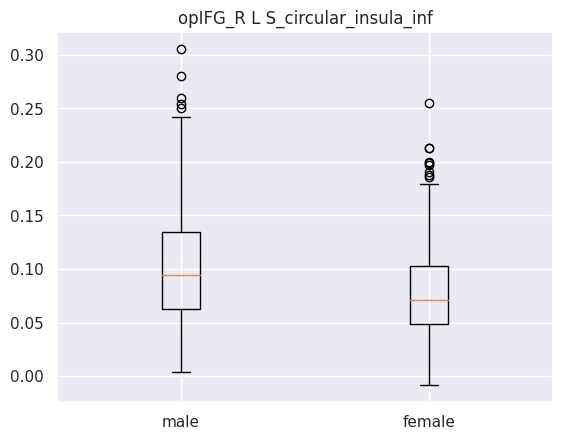

Ttest_indResult(statistic=5.209214517065878, pvalue=2.6567317528171283e-07)
male mean : 0.10079068
male std : 0.053574305
female mean : 0.079217285
female std : 0.04511931


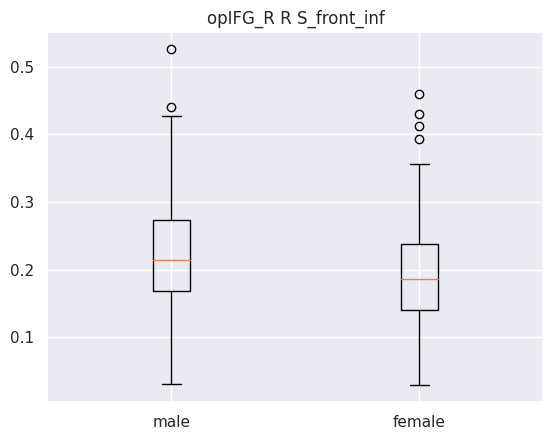

Ttest_indResult(statistic=5.115644842505535, pvalue=4.2829894742283856e-07)
male mean : 0.2219755
male std : 0.07697756
female mean : 0.1895739
female std : 0.0737671


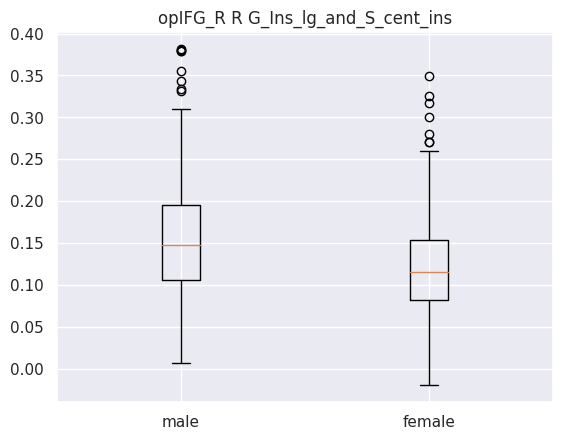

Ttest_indResult(statistic=5.739625646587781, pvalue=1.545440166893097e-08)
male mean : 0.15487437
male std : 0.06798104
female mean : 0.12380144
female std : 0.06101845


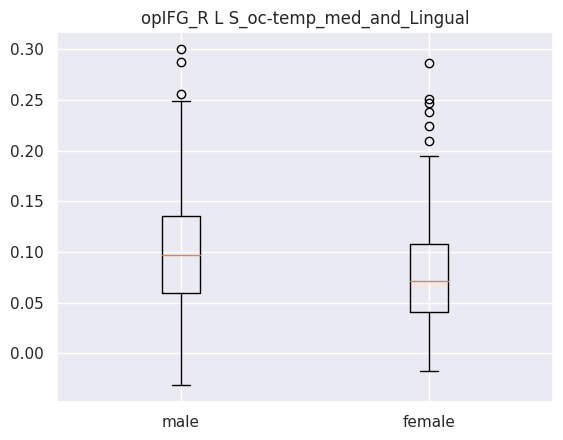

Ttest_indResult(statistic=4.827321528045811, pvalue=1.7812049807913685e-06)
male mean : 0.10082634
male std : 0.05712367
female mean : 0.07872187
female std : 0.05196897


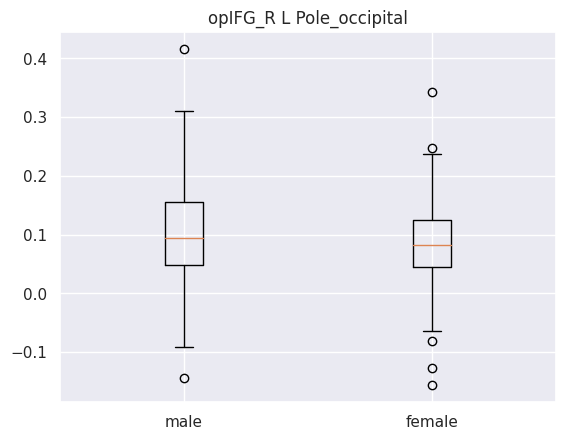

Ttest_indResult(statistic=2.893885724167742, pvalue=0.003951145819844653)
male mean : 0.104489796
male std : 0.079325154
female mean : 0.086915694
female std : 0.065369606


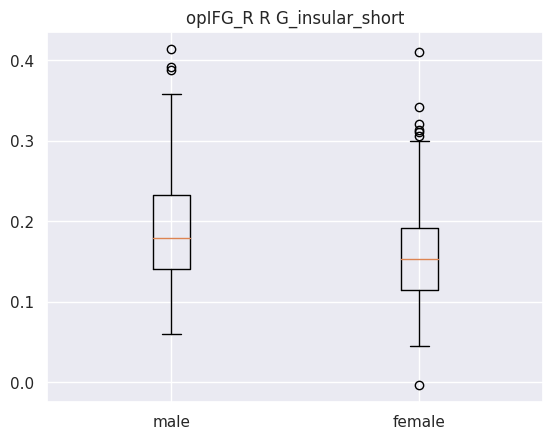

Ttest_indResult(statistic=6.0558814324037105, pvalue=2.541011688494163e-09)
male mean : 0.18950616
male std : 0.06412055
female mean : 0.15782672
female std : 0.060431454


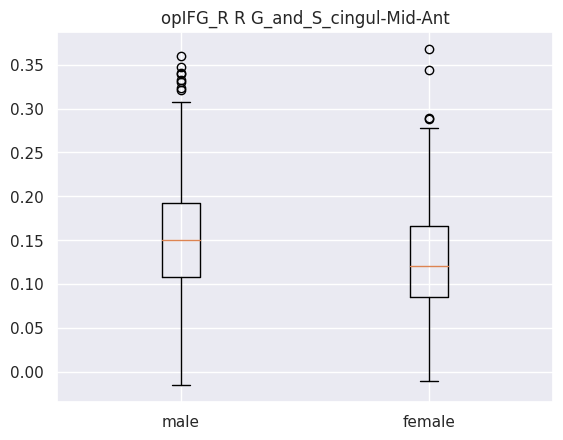

Ttest_indResult(statistic=5.189908662707754, pvalue=2.933594296577503e-07)
male mean : 0.15612759
male std : 0.06604462
female mean : 0.12868549
female std : 0.059933018


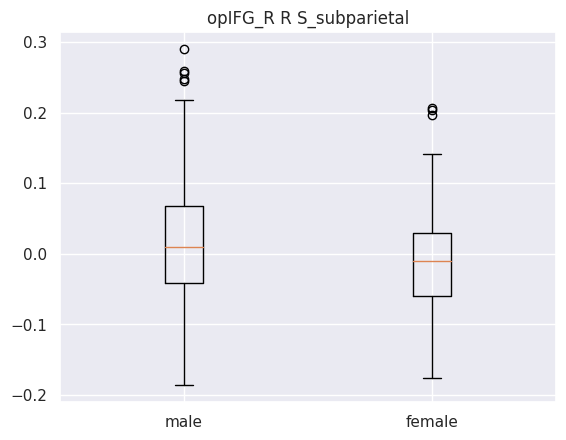

Ttest_indResult(statistic=4.565861064065717, pvalue=6.1028616247460355e-06)
male mean : 0.016530583
male std : 0.08771243
female mean : -0.012515795
female std : 0.06331841
                                  Region       Men     Women       P value
0      opIFG_R - R S_circular_insula_inf  0.106712  0.084175  2.429844e-07
1      opIFG_R - L G_oc-temp_lat-fusifor  0.156210  0.125283  1.609203e-08
2      opIFG_R - L S_circular_insula_inf  0.100791  0.079217  2.656732e-07
3                opIFG_R - R S_front_inf  0.221976  0.189574  4.282989e-07
4    opIFG_R - R G_Ins_lg_and_S_cent_ins  0.154874  0.123801  1.545440e-08
5  opIFG_R - L S_oc-temp_med_and_Lingual  0.100826  0.078722  1.781205e-06
6             opIFG_R - L Pole_occipital  0.104490  0.086916  3.951146e-03
7            opIFG_R - R G_insular_short  0.189506  0.157827  2.541012e-09
8     opIFG_R - R G_and_S_cingul-Mid-Ant  0.156128  0.128685  2.933594e-07
9              opIFG_R - R S_subparietal  0.016531 -0.012516  6.102862e-06


In [40]:
rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_L

     coefficient    seed                       labels
9       0.190456  pITG_L      L G_cingul-Post-ventral
26      0.166773  pITG_L             L G_parietal_sup
20      0.162700  pITG_L      L G_oc-temp_lat-fusifor
86      0.148229  pITG_L        R G_front_inf-Orbital
55      0.140414  pITG_L  L S_intrapariet_and_P_trans
125     0.128243  pITG_L                R S_front_inf
83      0.125650  pITG_L      R G_cingul-Post-ventral
4       0.123933  pITG_L   L G_and_S_transv_frontopol
115     0.119266  pITG_L             R Pole_occipital
66      0.117355  pITG_L              L S_postcentral
The mean accuracy : 0.8041539823008849
The standard deviation of the accuracy : 0.038765247723237035
The lower boundry of the confidance interval of the accuracy : 0.7281740967633403
The upper boundry of the confidance interval of the accuracy : 0.8801338678384294


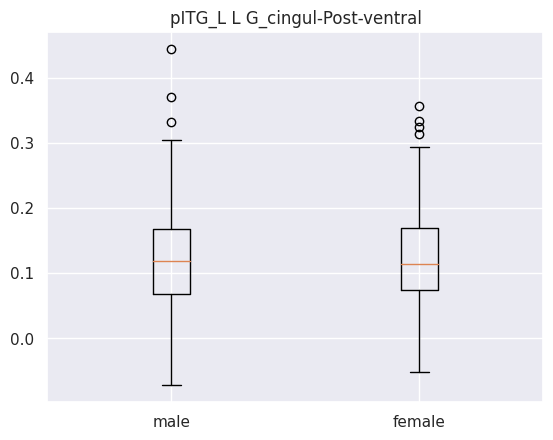

Ttest_indResult(statistic=0.003224637189575209, pvalue=0.9974282484204979)
male mean : 0.121866316
male std : 0.07354929
female mean : 0.121846415
female std : 0.07316029


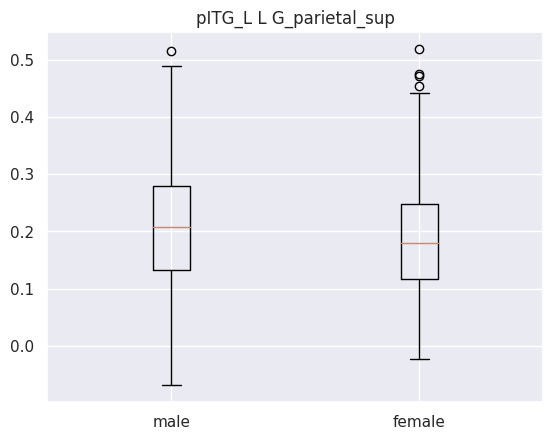

Ttest_indResult(statistic=2.7763339121273996, pvalue=0.005678905026620297)
male mean : 0.21009725
male std : 0.10720409
female mean : 0.18630977
female std : 0.09693752


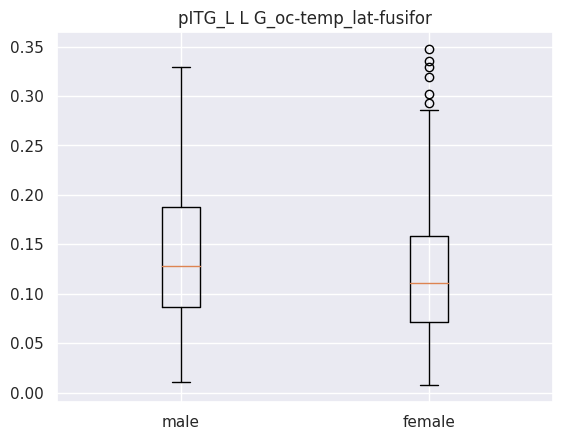

Ttest_indResult(statistic=3.1560770508029488, pvalue=0.0016837811636561792)
male mean : 0.13884458
male std : 0.06570245
female mean : 0.1213442
female std : 0.06606331


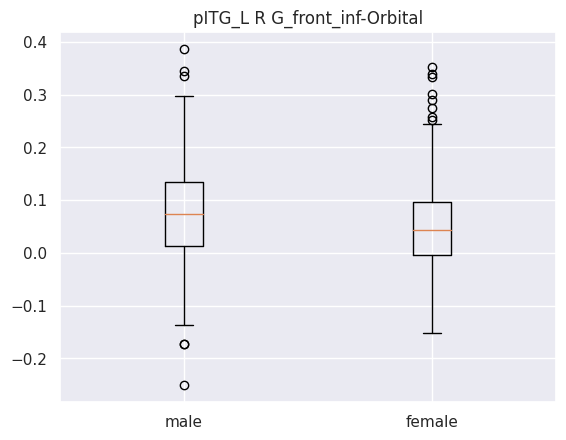

Ttest_indResult(statistic=2.720946268405945, pvalue=0.006709080997868932)
male mean : 0.07330693
male std : 0.09566736
female mean : 0.052528843
female std : 0.08628308


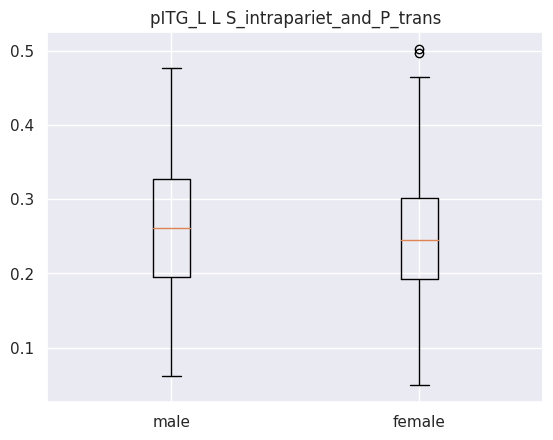

Ttest_indResult(statistic=2.210150274396303, pvalue=0.0274926630574435)
male mean : 0.2640814
male std : 0.08494383
female mean : 0.24852245
female std : 0.08253721


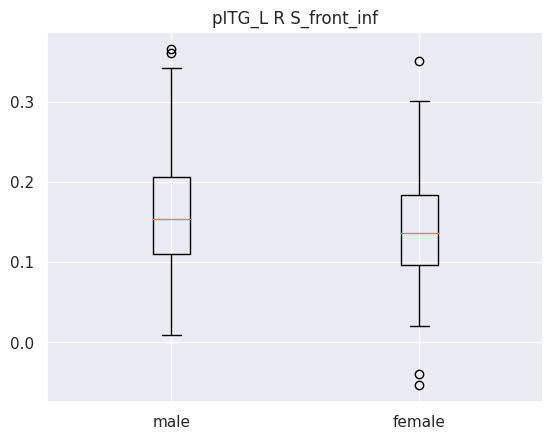

Ttest_indResult(statistic=3.4759879269197254, pvalue=0.00054786137558171)
male mean : 0.16004132
male std : 0.06862248
female mean : 0.14065996
female std : 0.06415676


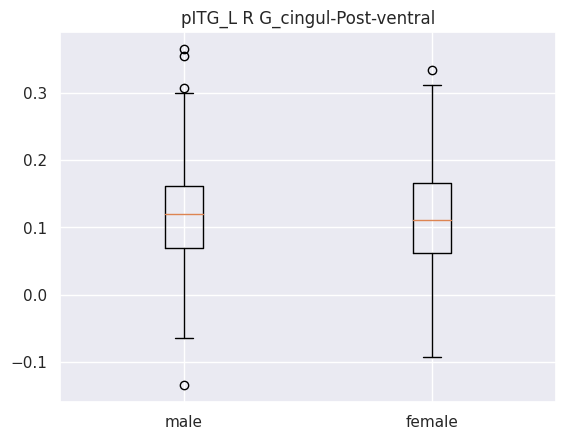

Ttest_indResult(statistic=0.09601695539493649, pvalue=0.9235409725531385)
male mean : 0.11851825
male std : 0.07418913
female mean : 0.11792118
female std : 0.07364736


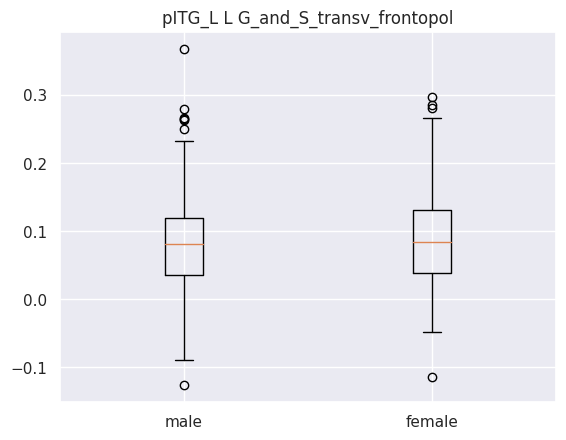

Ttest_indResult(statistic=-0.7998488085717543, pvalue=0.4241327774894412)
male mean : 0.083293684
male std : 0.06904808
female mean : 0.08794802
female std : 0.06924354


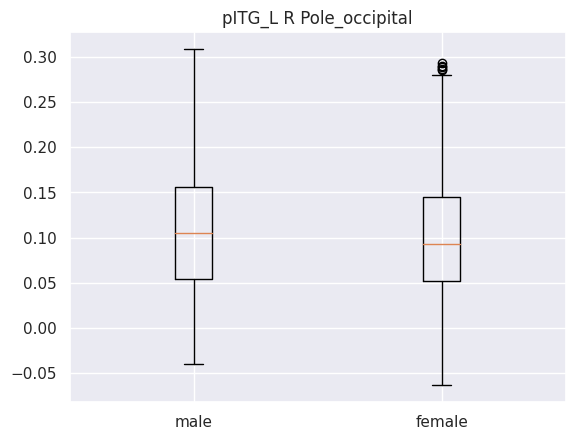

Ttest_indResult(statistic=1.3916516819772504, pvalue=0.16457263767872615)
male mean : 0.11096361
male std : 0.07007518
female mean : 0.10281154
female std : 0.06921456


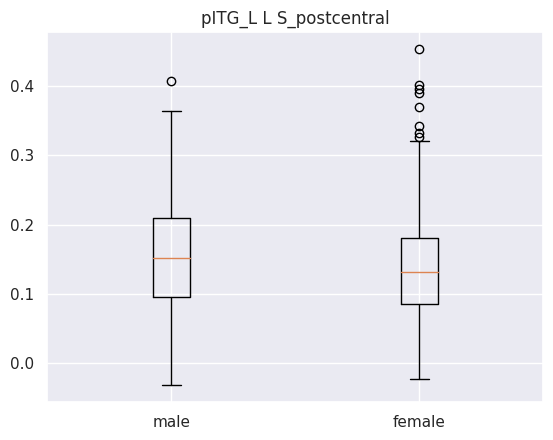

Ttest_indResult(statistic=2.5890680689210814, pvalue=0.009870224921455407)
male mean : 0.15819883
male std : 0.08342346
female mean : 0.14057475
female std : 0.07864947
                                 Region       Men     Women   P value
0      pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
1             pITG_L - L G_parietal_sup  0.210097  0.186310  0.005679
2      pITG_L - L G_oc-temp_lat-fusifor  0.138845  0.121344  0.001684
3        pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4  pITG_L - L S_intrapariet_and_P_trans  0.264081  0.248522  0.027493
5                pITG_L - R S_front_inf  0.160041  0.140660  0.000548
6      pITG_L - R G_cingul-Post-ventral  0.118518  0.117921  0.923541
7   pITG_L - L G_and_S_transv_frontopol  0.083294  0.087948  0.424133
8             pITG_L - R Pole_occipital  0.110964  0.102812  0.164573
9              pITG_L - L S_postcentral  0.158199  0.140575  0.009870


In [42]:
rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_R

     coefficient    seed                     labels
20      0.206739  pITG_R    L G_oc-temp_lat-fusifor
125     0.165472  pITG_R              R S_front_inf
72      0.149122  pITG_R           L S_temporal_sup
83      0.140567  pITG_R    R G_cingul-Post-ventral
84      0.120418  pITG_R                 R G_cuneus
90      0.108909  pITG_R  R G_Ins_lg_and_S_cent_ins
66      0.108341  pITG_R            L S_postcentral
47      0.103744  pITG_R    L S_circular_insula_inf
80      0.099782  pITG_R   R G_and_S_cingul-Mid-Ant
144     0.096160  pITG_R            R S_subparietal
The mean accuracy : 0.803787610619469
The standard deviation of the accuracy : 0.03911586112149067
The lower boundry of the confidance interval of the accuracy : 0.7271205228213473
The upper boundry of the confidance interval of the accuracy : 0.8804546984175907


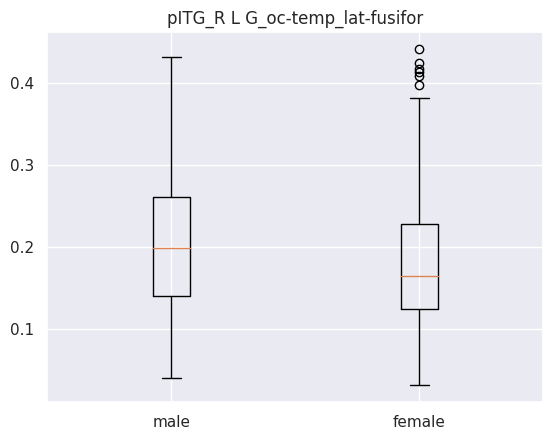

Ttest_indResult(statistic=3.277484422127677, pvalue=0.0011113280120916263)
male mean : 0.20170005
male std : 0.08080574
female mean : 0.17975447
female std : 0.07849484


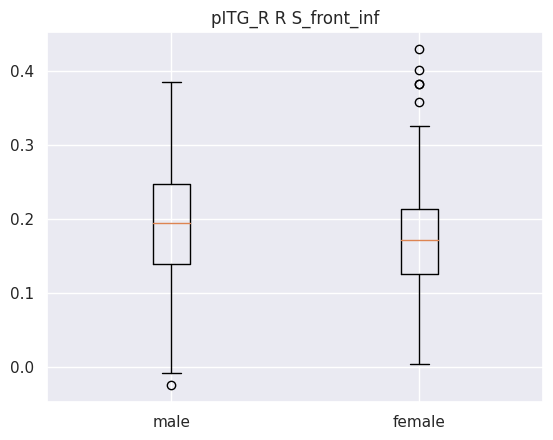

Ttest_indResult(statistic=3.5885077475270313, pvalue=0.0003613019074599524)
male mean : 0.19545709
male std : 0.07119095
female mean : 0.17458448
female std : 0.06728852


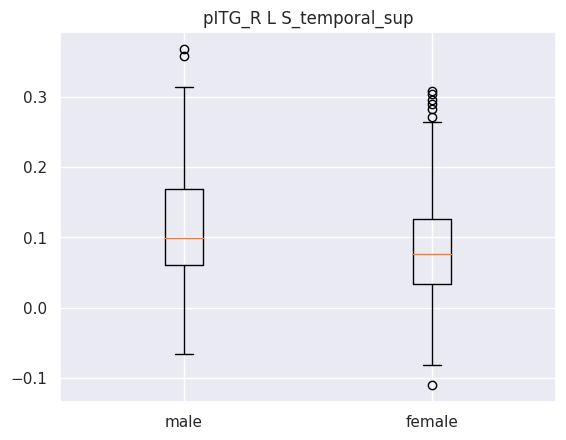

Ttest_indResult(statistic=5.074089324479851, pvalue=5.28243122629593e-07)
male mean : 0.11588306
male std : 0.08326067
female mean : 0.082715824
female std : 0.072522454


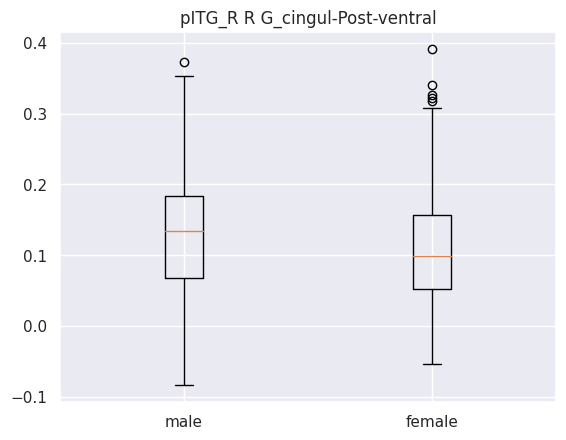

Ttest_indResult(statistic=2.7984808070680014, pvalue=0.0053086937836487255)
male mean : 0.1303599
male std : 0.0845541
female mean : 0.110936716
female std : 0.080651894


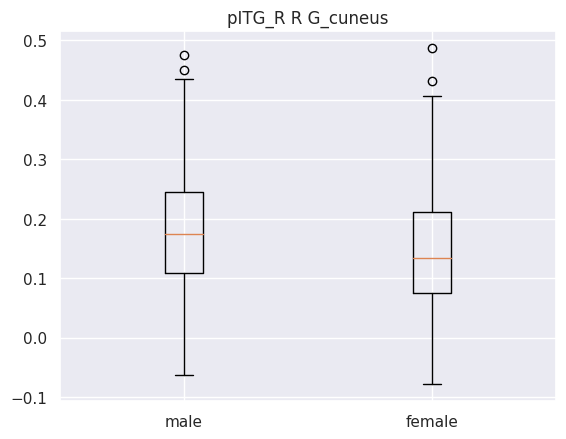

Ttest_indResult(statistic=3.905515058580817, pvalue=0.00010533317279626685)
male mean : 0.18062297
male std : 0.0992545
female mean : 0.14835264
female std : 0.09727066


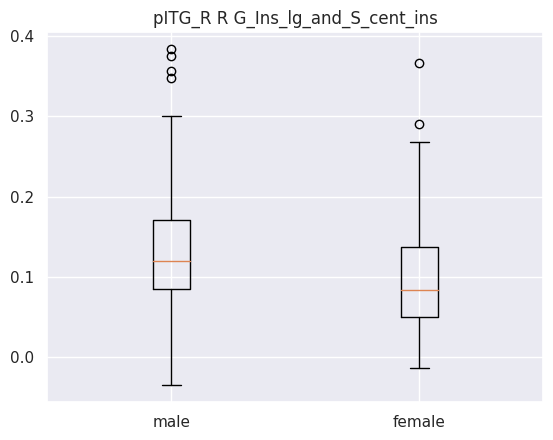

Ttest_indResult(statistic=5.819424451811164, pvalue=9.874874542197165e-09)
male mean : 0.12975526
male std : 0.07115671
female mean : 0.09711951
female std : 0.06249378


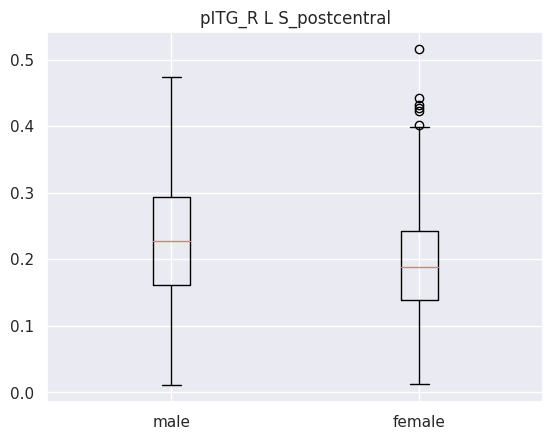

Ttest_indResult(statistic=4.500613990694751, pvalue=8.223187917577433e-06)
male mean : 0.22811967
male std : 0.08919472
female mean : 0.19511805
female std : 0.08533056


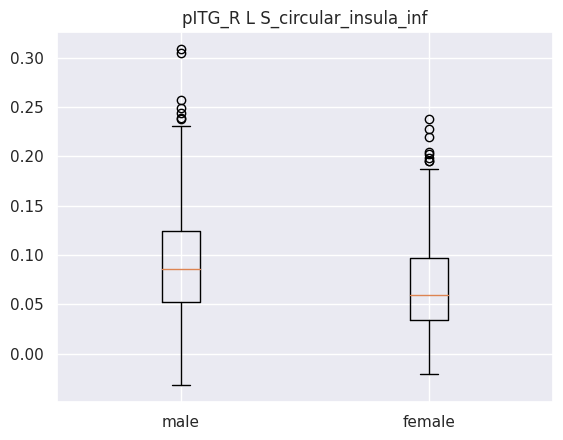

Ttest_indResult(statistic=5.312904799307869, pvalue=1.5516954477485133e-07)
male mean : 0.093431704
male std : 0.055914264
female mean : 0.07025469
female std : 0.048053518


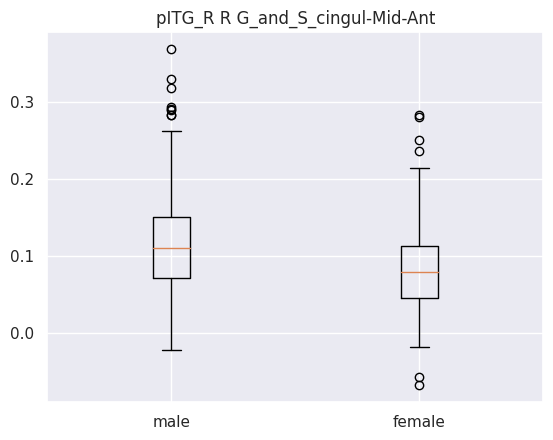

Ttest_indResult(statistic=6.329006502100034, pvalue=5.010626156152059e-10)
male mean : 0.116088144
male std : 0.06703518
female mean : 0.08355036
female std : 0.05546378


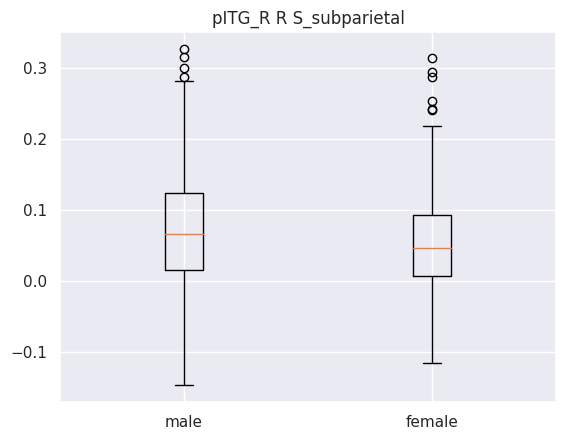

Ttest_indResult(statistic=3.002816719898178, pvalue=0.002792640318471544)
male mean : 0.07293796
male std : 0.08409094
female mean : 0.053484038
female std : 0.07029177
                               Region       Men     Women       P value
0    pITG_R - L G_oc-temp_lat-fusifor  0.201700  0.179754  1.111328e-03
1              pITG_R - R S_front_inf  0.195457  0.174584  3.613019e-04
2           pITG_R - L S_temporal_sup  0.115883  0.082716  5.282431e-07
3    pITG_R - R G_cingul-Post-ventral  0.130360  0.110937  5.308694e-03
4                 pITG_R - R G_cuneus  0.180623  0.148353  1.053332e-04
5  pITG_R - R G_Ins_lg_and_S_cent_ins  0.129755  0.097120  9.874875e-09
6            pITG_R - L S_postcentral  0.228120  0.195118  8.223188e-06
7    pITG_R - L S_circular_insula_inf  0.093432  0.070255  1.551695e-07
8   pITG_R - R G_and_S_cingul-Mid-Ant  0.116088  0.083550  5.010626e-10
9            pITG_R - R S_subparietal  0.072938  0.053484  2.792640e-03


In [44]:
rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_L

     coefficient          seed                       labels
20      0.184896  planumtemp_L      L G_oc-temp_lat-fusifor
60      0.169655  planumtemp_L  L S_oc-temp_med_and_Lingual
94      0.149563  planumtemp_L      R G_oc-temp_lat-fusifor
108     0.142585  planumtemp_L      R G_temp_sup-Plan_polar
15      0.121094  planumtemp_L                L G_front_sup
43      0.116258  planumtemp_L                L S_calcarine
66      0.115378  planumtemp_L              L S_postcentral
80      0.101375  planumtemp_L     R G_and_S_cingul-Mid-Ant
90      0.101147  planumtemp_L    R G_Ins_lg_and_S_cent_ins
47      0.100562  planumtemp_L      L S_circular_insula_inf
The mean accuracy : 0.7950212389380531
The standard deviation of the accuracy : 0.03926348444477098
The lower boundry of the confidance interval of the accuracy : 0.718064809426302
The upper boundry of the confidance interval of the accuracy : 0.8719776684498042


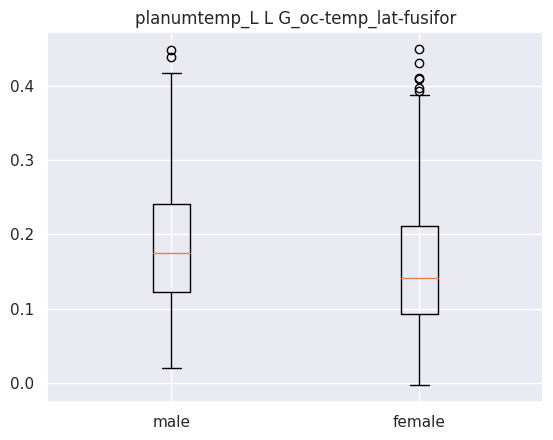

Ttest_indResult(statistic=3.8845996245259564, pvalue=0.00011456707679985891)
male mean : 0.18645073
male std : 0.08589947
female mean : 0.1582872
female std : 0.08638312


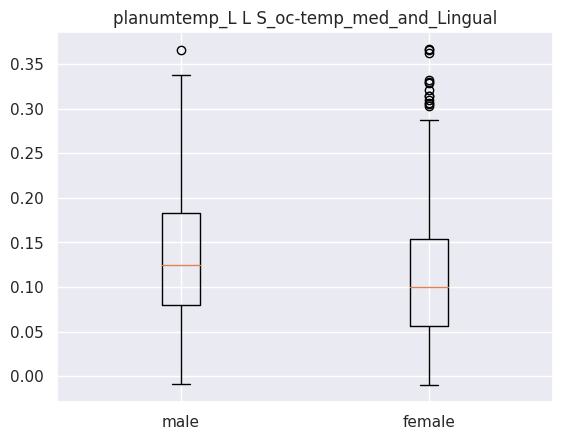

Ttest_indResult(statistic=3.0202118325102205, pvalue=0.002639538408935342)
male mean : 0.13396002
male std : 0.073068485
female mean : 0.11491338
female std : 0.0765271


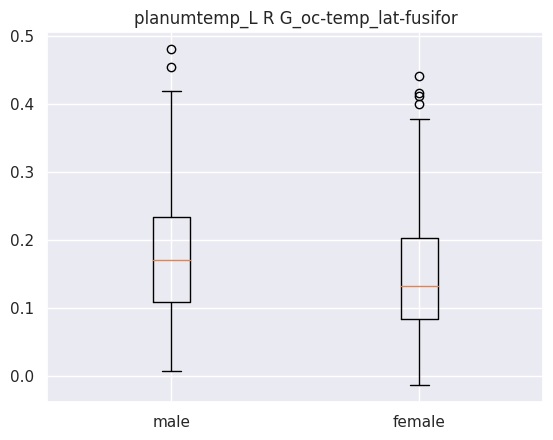

Ttest_indResult(statistic=3.8443518847362848, pvalue=0.00013453025291976489)
male mean : 0.17783996
male std : 0.08768854
female mean : 0.14997594
female std : 0.08477295


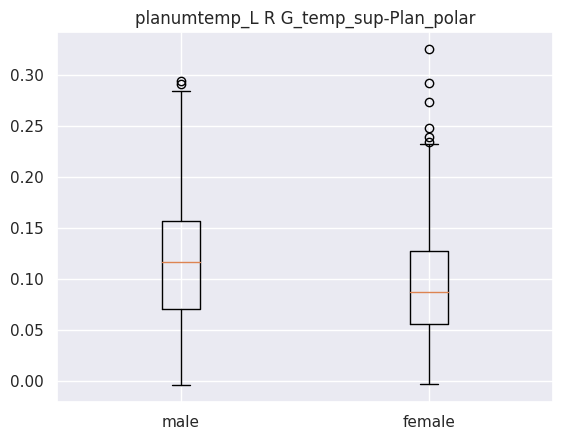

Ttest_indResult(statistic=4.70907580168869, pvalue=3.1312814933031638e-06)
male mean : 0.120655425
male std : 0.05935306
female mean : 0.09793018
female std : 0.055564255


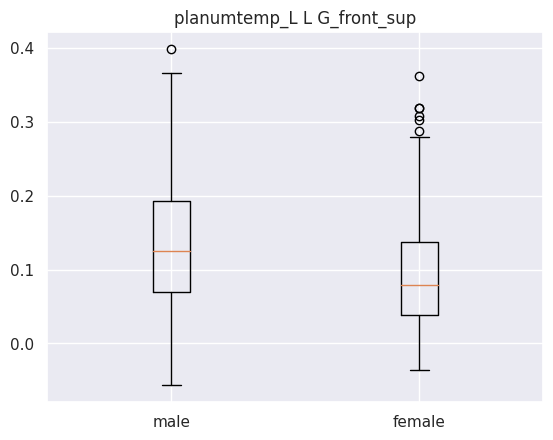

Ttest_indResult(statistic=6.277384980515788, pvalue=6.841155101343653e-10)
male mean : 0.13300735
male std : 0.08449037
female mean : 0.09150557
female std : 0.07307536


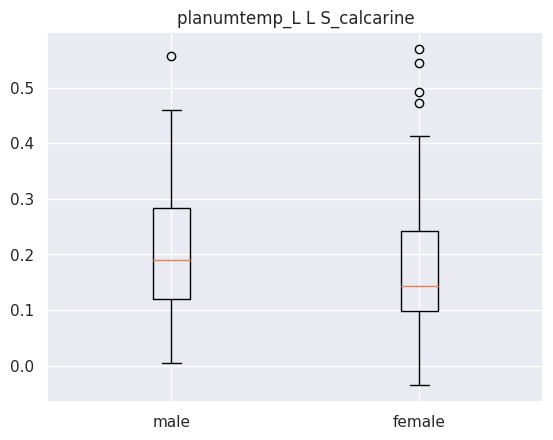

Ttest_indResult(statistic=3.6505600100215787, pvalue=0.0002858230109069697)
male mean : 0.20659167
male std : 0.107639536
female mean : 0.17391653
female std : 0.10526273


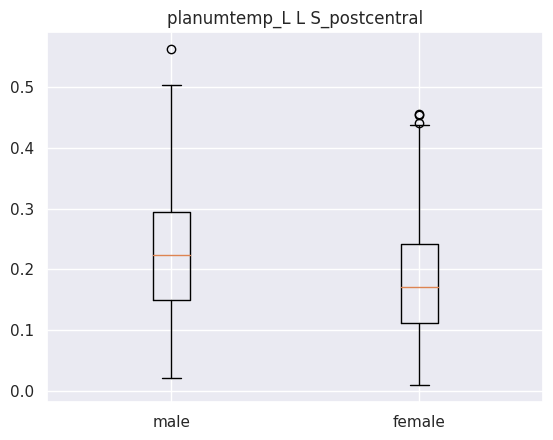

Ttest_indResult(statistic=5.208819134368209, pvalue=2.6621392728203895e-07)
male mean : 0.22551109
male std : 0.1019243
female mean : 0.18211527
female std : 0.09642126


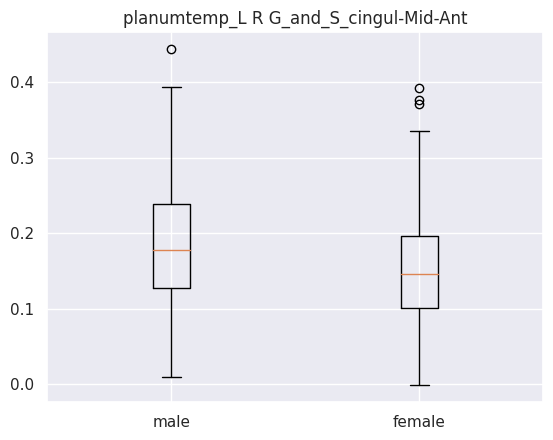

Ttest_indResult(statistic=4.941458546899931, pvalue=1.0217179140328071e-06)
male mean : 0.18532187
male std : 0.081872195
female mean : 0.15326016
female std : 0.07274537


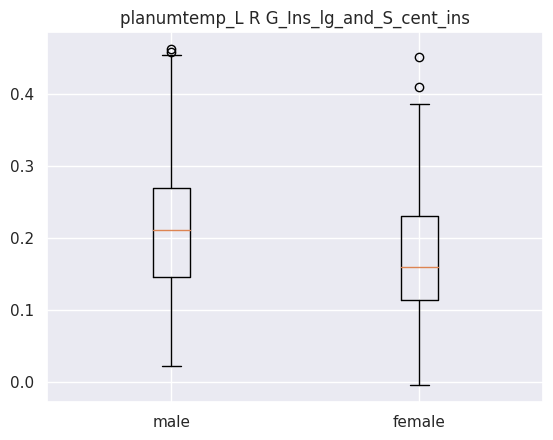

Ttest_indResult(statistic=4.782700624471331, pvalue=2.206867368720522e-06)
male mean : 0.21097915
male std : 0.08802379
female mean : 0.17569473
female std : 0.08737143


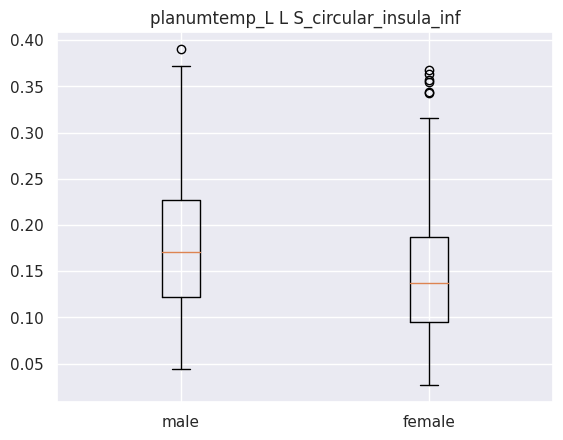

Ttest_indResult(statistic=4.687780389458475, pvalue=3.461763223277321e-06)
male mean : 0.17687188
male std : 0.070358895
female mean : 0.14962009
female std : 0.0679686
                                       Region       Men     Women  \
0      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287   
1  planumtemp_L - L S_oc-temp_med_and_Lingual  0.133960  0.114913   
2      planumtemp_L - R G_oc-temp_lat-fusifor  0.177840  0.149976   
3      planumtemp_L - R G_temp_sup-Plan_polar  0.120655  0.097930   
4                planumtemp_L - L G_front_sup  0.133007  0.091506   
5                planumtemp_L - L S_calcarine  0.206592  0.173917   
6              planumtemp_L - L S_postcentral  0.225511  0.182115   
7     planumtemp_L - R G_and_S_cingul-Mid-Ant  0.185322  0.153260   
8    planumtemp_L - R G_Ins_lg_and_S_cent_ins  0.210979  0.175695   
9      planumtemp_L - L S_circular_insula_inf  0.176872  0.149620   

        P value  
0  1.145671e-04  
1  2.639538e-03  
2  1.345303e-04  

In [46]:
rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_R

     coefficient          seed                       labels
72      0.189775  planumtemp_R             L S_temporal_sup
47      0.164223  planumtemp_R      L S_circular_insula_inf
60      0.159426  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.159356  planumtemp_R                L S_calcarine
108     0.156959  planumtemp_R      R G_temp_sup-Plan_polar
121     0.154331  planumtemp_R      R S_circular_insula_inf
20      0.148078  planumtemp_R      L G_oc-temp_lat-fusifor
78      0.115579  planumtemp_R   R G_and_S_transv_frontopol
15      0.112023  planumtemp_R                L G_front_sup
80      0.111868  planumtemp_R     R G_and_S_cingul-Mid-Ant
The mean accuracy : 0.7848601769911504
The standard deviation of the accuracy : 0.039920238590652524
The lower boundry of the confidance interval of the accuracy : 0.7066165093534714
The upper boundry of the confidance interval of the accuracy : 0.8631038446288294


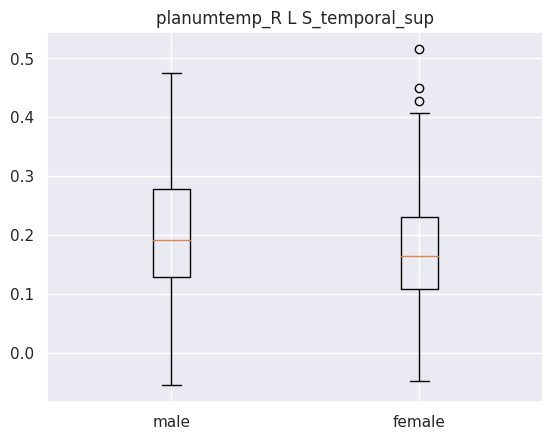

Ttest_indResult(statistic=3.6109779662087154, pvalue=0.00033203656606058823)
male mean : 0.20394091
male std : 0.10588711
female mean : 0.1741676
female std : 0.09061758


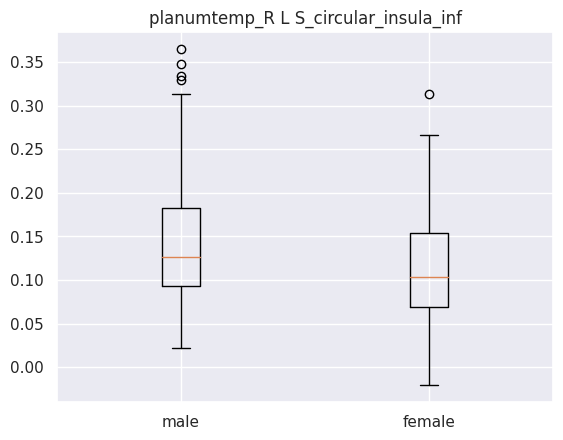

Ttest_indResult(statistic=5.007456320849462, pvalue=7.371792367211497e-07)
male mean : 0.14035343
male std : 0.06475694
female mean : 0.11432696
female std : 0.05906692


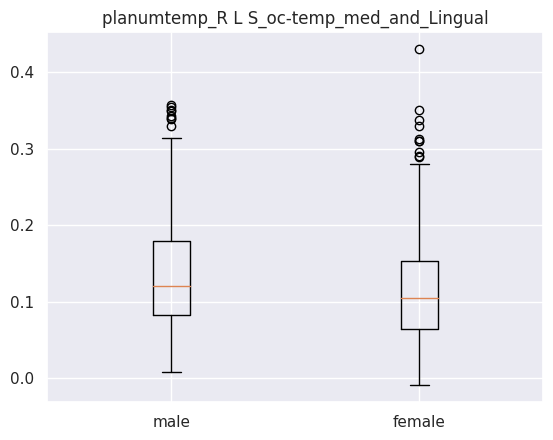

Ttest_indResult(statistic=3.062423358968075, pvalue=0.002299457741086362)
male mean : 0.13526098
male std : 0.07310231
female mean : 0.116651125
female std : 0.07144451


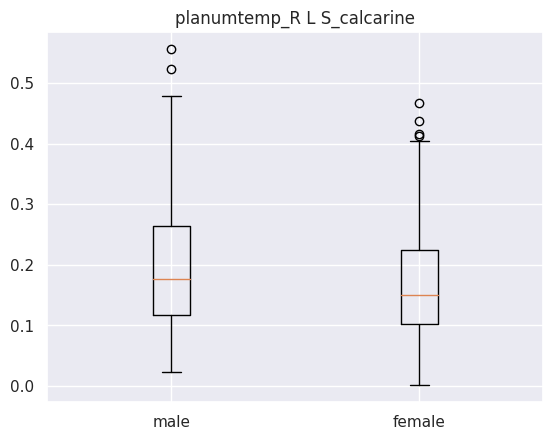

Ttest_indResult(statistic=3.1724387476981906, pvalue=0.0015932968935781927)
male mean : 0.19657883
male std : 0.10440613
female mean : 0.1700965
female std : 0.09448411


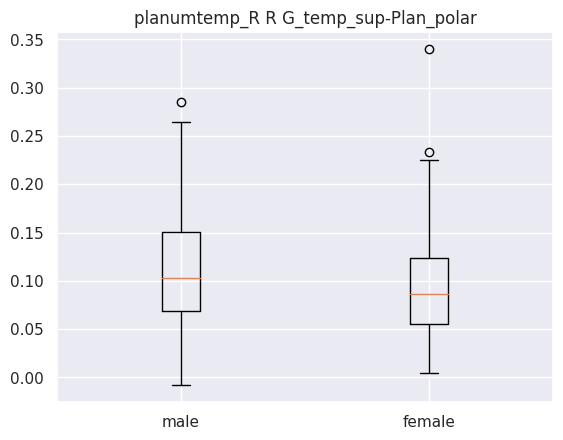

Ttest_indResult(statistic=3.6723430932200616, pvalue=0.0002630404119373645)
male mean : 0.111256644
male std : 0.05620358
female mean : 0.09470312
female std : 0.051186122


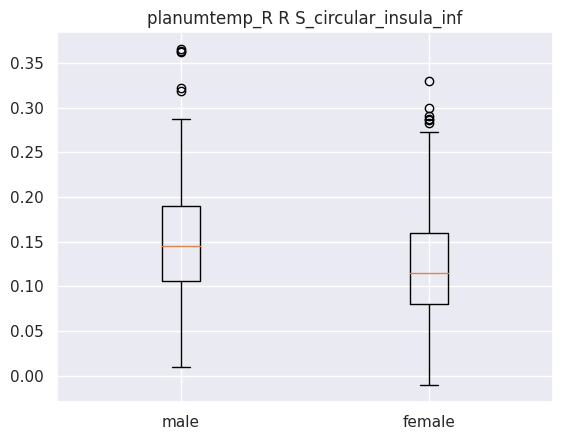

Ttest_indResult(statistic=5.169833575307031, pvalue=3.2510547257426204e-07)
male mean : 0.15255034
male std : 0.06357165
female mean : 0.12557979
female std : 0.060606852


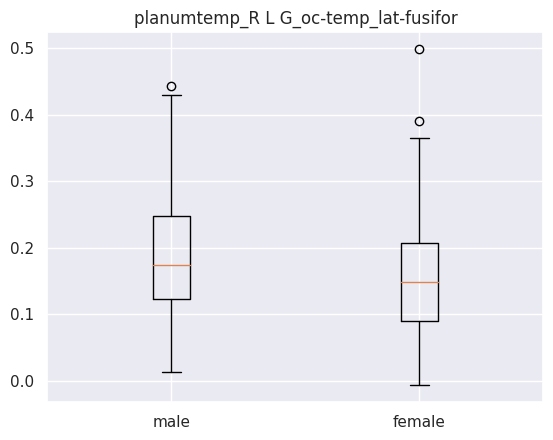

Ttest_indResult(statistic=4.196349569094404, pvalue=3.147372322299068e-05)
male mean : 0.18705179
male std : 0.08811469
female mean : 0.15669796
female std : 0.08405948


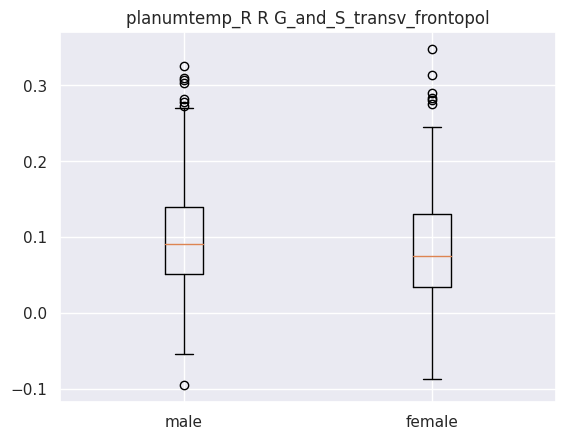

Ttest_indResult(statistic=2.4450835666843, pvalue=0.014784554897756937)
male mean : 0.09999801
male std : 0.07366885
female mean : 0.084834725
female std : 0.073725015


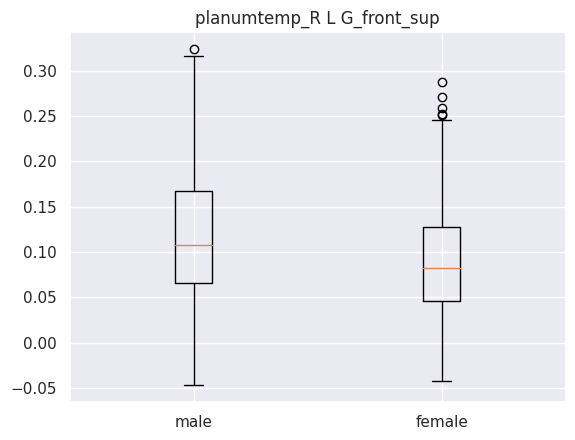

Ttest_indResult(statistic=4.713042431410122, pvalue=3.0731724676130183e-06)
male mean : 0.11826675
male std : 0.07605848
female mean : 0.09100003
female std : 0.06176032


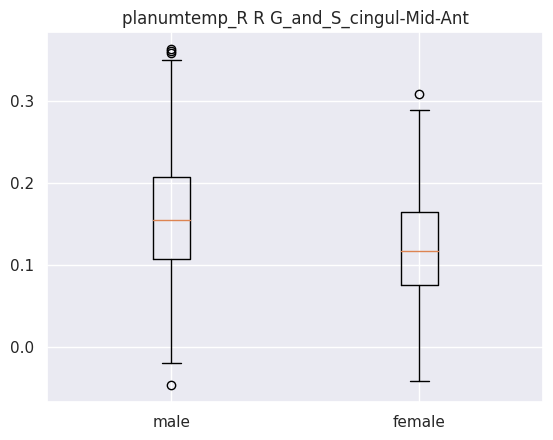

Ttest_indResult(statistic=6.041387502102459, pvalue=2.765056754704192e-09)
male mean : 0.15823741
male std : 0.07490632
female mean : 0.12321305
female std : 0.063253865
                                       Region       Men     Women  \
0             planumtemp_R - L S_temporal_sup  0.203941  0.174168   
1      planumtemp_R - L S_circular_insula_inf  0.140353  0.114327   
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651   
3                planumtemp_R - L S_calcarine  0.196579  0.170097   
4      planumtemp_R - R G_temp_sup-Plan_polar  0.111257  0.094703   
5      planumtemp_R - R S_circular_insula_inf  0.152550  0.125580   
6      planumtemp_R - L G_oc-temp_lat-fusifor  0.187052  0.156698   
7   planumtemp_R - R G_and_S_transv_frontopol  0.099998  0.084835   
8                planumtemp_R - L G_front_sup  0.118267  0.091000   
9     planumtemp_R - R G_and_S_cingul-Mid-Ant  0.158237  0.123213   

        P value  
0  3.320366e-04  
1  7.371792e-07  
2  2.299458e-03 

In [48]:
rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all left seed

     coefficient          seed                       labels
349     0.100006        aMTG_L                L S_front_sup
300     0.089683        aMTG_L   L G_and_S_transv_frontopol
394     0.087961        aMTG_L       R G_pariet_inf-Angular
530     0.086534        pITG_L        R G_front_inf-Orbital
470     0.081788        pITG_L             L G_parietal_sup
453     0.077923        pITG_L      L G_cingul-Post-ventral
208     0.075931  planumtemp_L  L S_oc-temp_med_and_Lingual
569     0.073120        pITG_L                R S_front_inf
351     0.072263        aMTG_L  L S_intrapariet_and_P_trans
168     0.069281  planumtemp_L      L G_oc-temp_lat-fusifor
The mean accuracy : 0.9104362831858407
The standard deviation of the accuracy : 0.028102231489263784
The lower boundry of the confidance interval of the accuracy : 0.8553559094668837
The upper boundry of the confidance interval of the accuracy : 0.9655166569047977


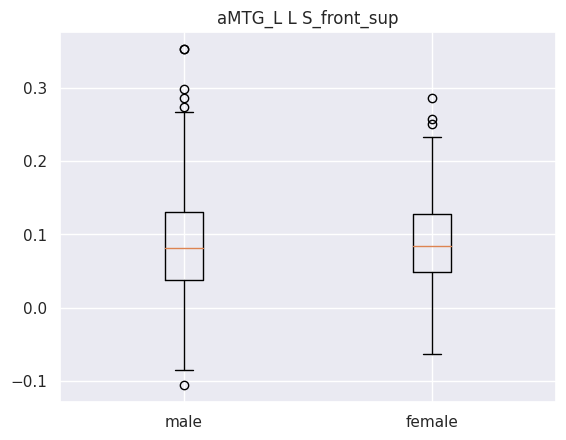

Ttest_indResult(statistic=-0.16306014953081052, pvalue=0.8705290727591274)
male mean : 0.08941226
male std : 0.07188258
female mean : 0.09030944
female std : 0.05921447


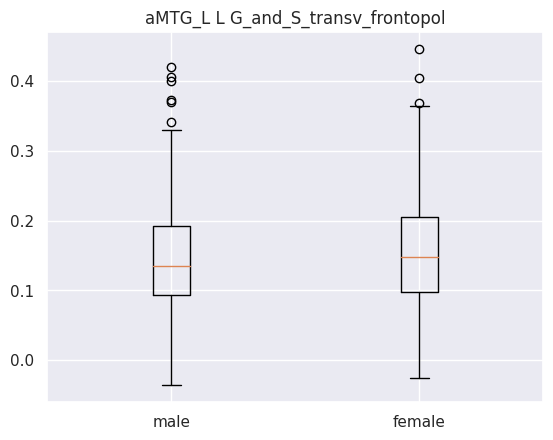

Ttest_indResult(statistic=-0.4347863513193104, pvalue=0.6638826490308001)
male mean : 0.15048955
male std : 0.07943841
female mean : 0.15334298
female std : 0.07672297


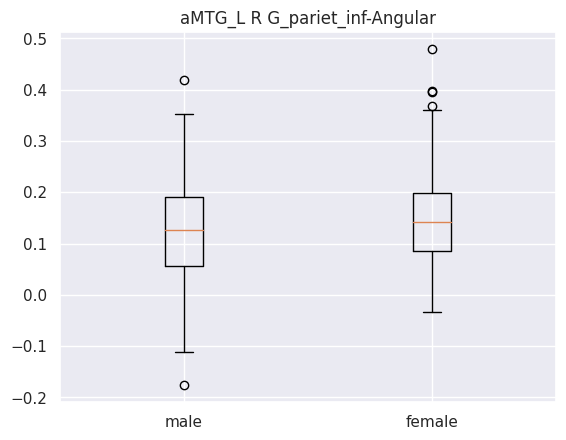

Ttest_indResult(statistic=-2.9146205507484293, pvalue=0.0037015702185267565)
male mean : 0.12457278
male std : 0.09838336
female mean : 0.1470128
female std : 0.08510771


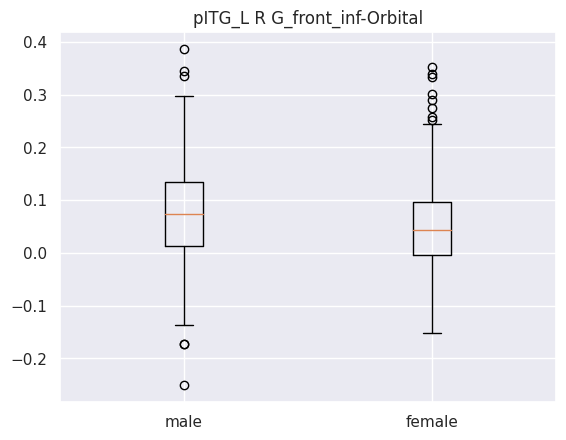

Ttest_indResult(statistic=2.720946268405945, pvalue=0.006709080997868932)
male mean : 0.07330693
male std : 0.09566736
female mean : 0.052528843
female std : 0.08628308


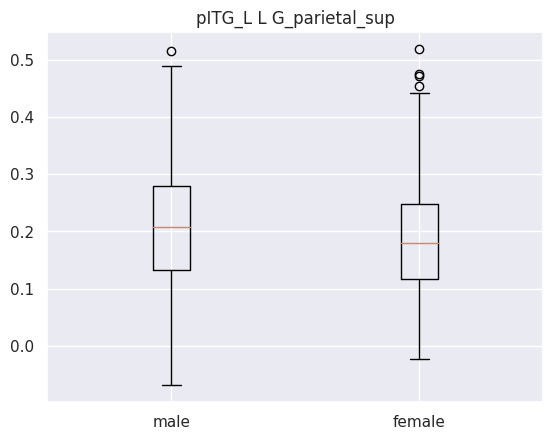

Ttest_indResult(statistic=2.7763339121273996, pvalue=0.005678905026620297)
male mean : 0.21009725
male std : 0.10720409
female mean : 0.18630977
female std : 0.09693752


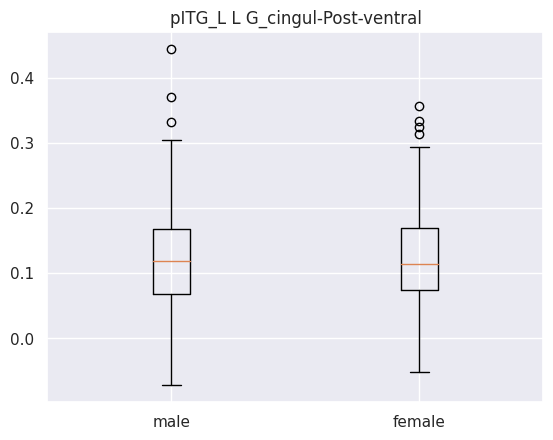

Ttest_indResult(statistic=0.003224637189575209, pvalue=0.9974282484204979)
male mean : 0.121866316
male std : 0.07354929
female mean : 0.121846415
female std : 0.07316029


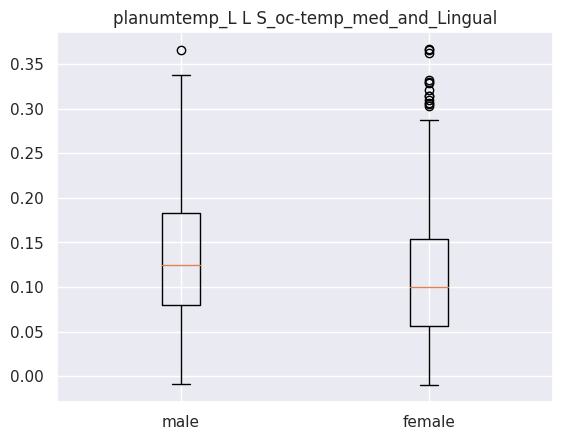

Ttest_indResult(statistic=3.0202118325102205, pvalue=0.002639538408935342)
male mean : 0.13396002
male std : 0.073068485
female mean : 0.11491338
female std : 0.0765271


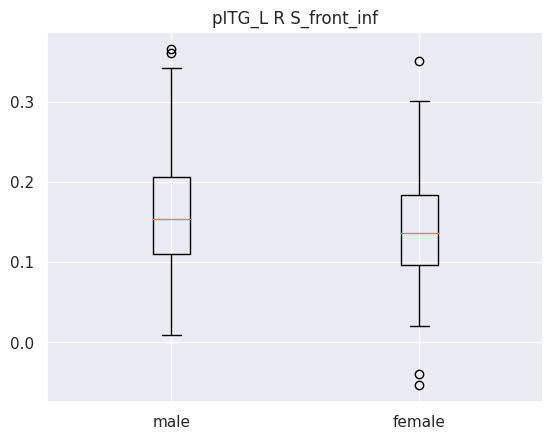

Ttest_indResult(statistic=3.4759879269197254, pvalue=0.00054786137558171)
male mean : 0.16004132
male std : 0.06862248
female mean : 0.14065996
female std : 0.06415676


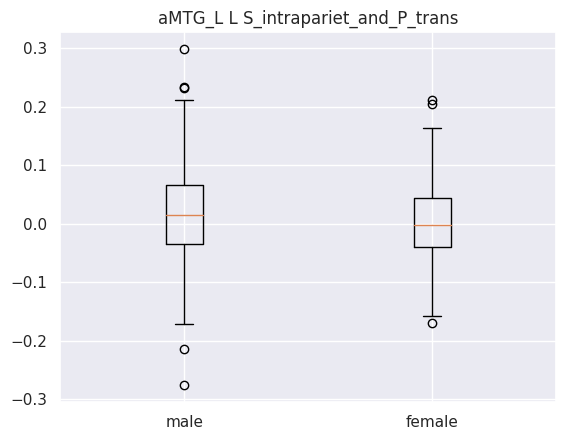

Ttest_indResult(statistic=1.5534617384302924, pvalue=0.12086984693044656)
male mean : 0.014690557
male std : 0.07998747
female mean : 0.005323266
female std : 0.06360493


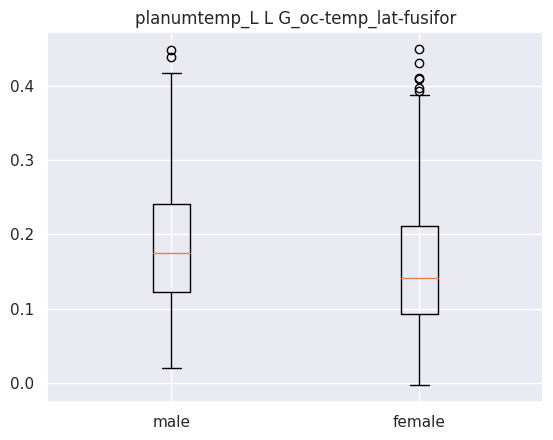

Ttest_indResult(statistic=3.8845996245259564, pvalue=0.00011456707679985891)
male mean : 0.18645073
male std : 0.08589947
female mean : 0.1582872
female std : 0.08638312
                                       Region       Men     Women   P value
0                      aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1         aMTG_L - L G_and_S_transv_frontopol  0.150490  0.153343  0.663883
2             aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
3              pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4                   pITG_L - L G_parietal_sup  0.210097  0.186310  0.005679
5            pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
6  planumtemp_L - L S_oc-temp_med_and_Lingual  0.133960  0.114913  0.002640
7                      pITG_L - R S_front_inf  0.160041  0.140660  0.000548
8        aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323  0.120870
9      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287  0.0

In [50]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all right seed

     coefficient          seed                       labels
464     0.100225        pITG_R      L G_oc-temp_lat-fusifor
349     0.098936        aMTG_R                L S_front_sup
191     0.089233  planumtemp_R                L S_calcarine
569     0.086085        pITG_R                R S_front_inf
379     0.081712        aMTG_R      R G_cingul-Post-ventral
144     0.080372       opIFG_R              R S_subparietal
300     0.078049        aMTG_R   L G_and_S_transv_frontopol
431     0.077773        aMTG_R          R S_orbital_lateral
208     0.077384  planumtemp_R  L S_oc-temp_med_and_Lingual
220     0.076363  planumtemp_R             L S_temporal_sup
The mean accuracy : 0.9012778761061947
The standard deviation of the accuracy : 0.029758982557172946
The lower boundry of the confidance interval of the accuracy : 0.8429502702941357
The upper boundry of the confidance interval of the accuracy : 0.9596054819182537


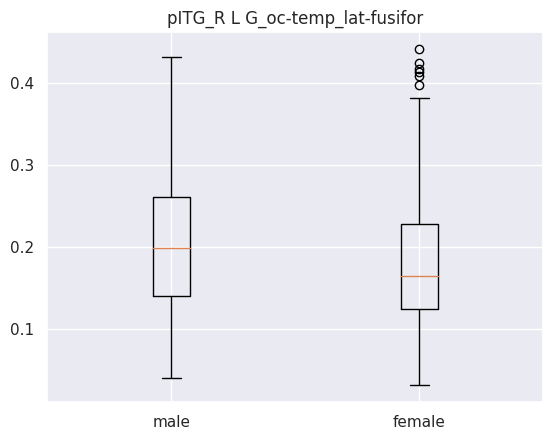

Ttest_indResult(statistic=3.277484422127677, pvalue=0.0011113280120916263)
male mean : 0.20170005
male std : 0.08080574
female mean : 0.17975447
female std : 0.07849484


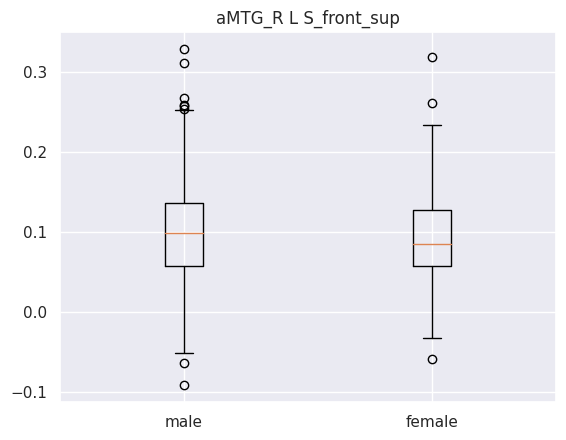

Ttest_indResult(statistic=1.3124198838062673, pvalue=0.18990857956645163)
male mean : 0.09976947
male std : 0.067789316
female mean : 0.0929379
female std : 0.056244437


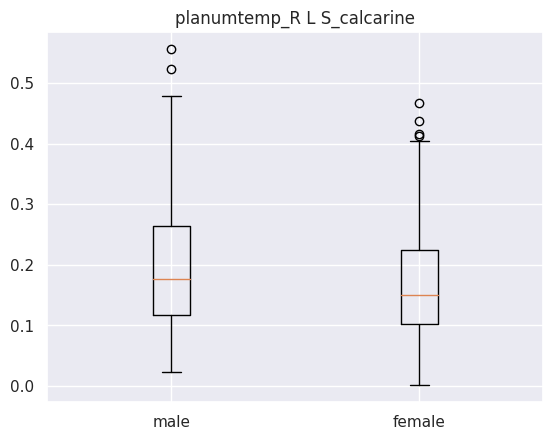

Ttest_indResult(statistic=3.1724387476981906, pvalue=0.0015932968935781927)
male mean : 0.19657883
male std : 0.10440613
female mean : 0.1700965
female std : 0.09448411


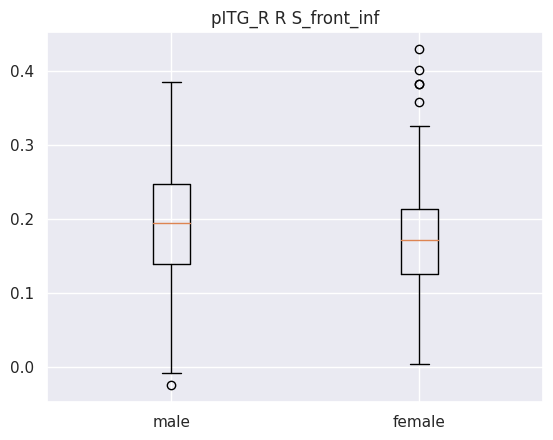

Ttest_indResult(statistic=3.5885077475270313, pvalue=0.0003613019074599524)
male mean : 0.19545709
male std : 0.07119095
female mean : 0.17458448
female std : 0.06728852


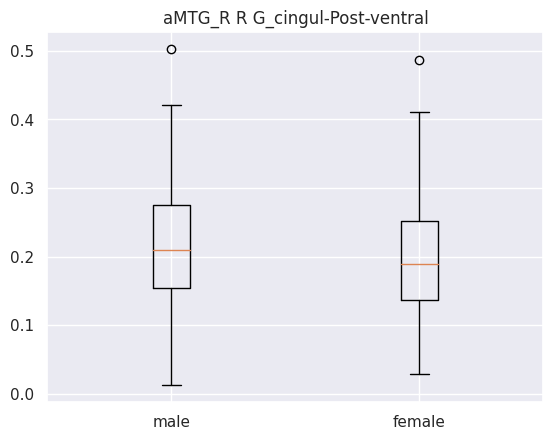

Ttest_indResult(statistic=2.917380364114057, pvalue=0.003669457916040501)
male mean : 0.2160543
male std : 0.08432504
female mean : 0.1958651
female std : 0.08039957


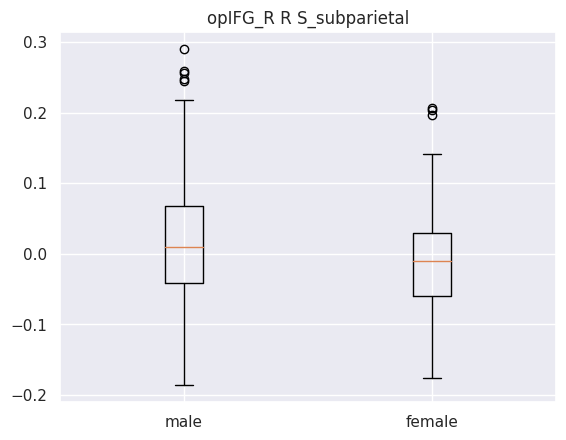

Ttest_indResult(statistic=4.565861064065717, pvalue=6.1028616247460355e-06)
male mean : 0.016530583
male std : 0.08771243
female mean : -0.012515795
female std : 0.06331841


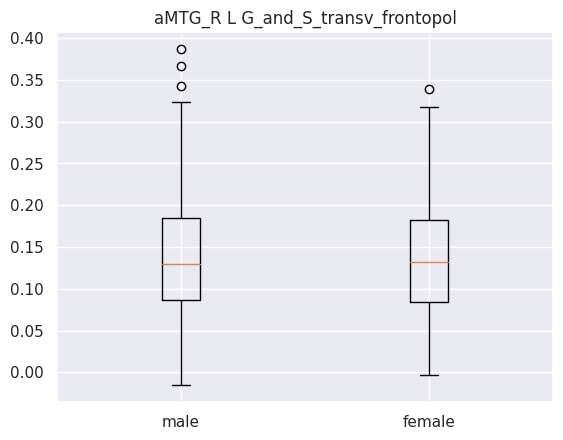

Ttest_indResult(statistic=0.6162901573548603, pvalue=0.5379499383607076)
male mean : 0.14077756
male std : 0.07301095
female mean : 0.13714556
female std : 0.06736406


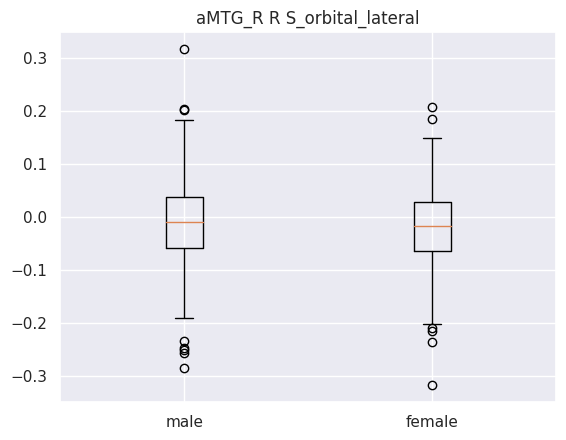

Ttest_indResult(statistic=0.8920637250991912, pvalue=0.37273652594724915)
male mean : -0.010003094
male std : 0.08398575
female mean : -0.016048837
female std : 0.07744561


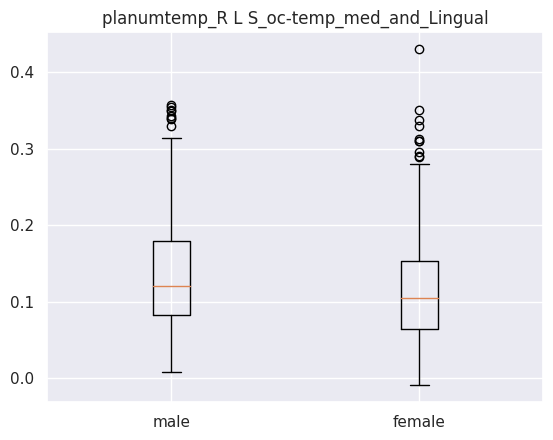

Ttest_indResult(statistic=3.062423358968075, pvalue=0.002299457741086362)
male mean : 0.13526098
male std : 0.07310231
female mean : 0.116651125
female std : 0.07144451


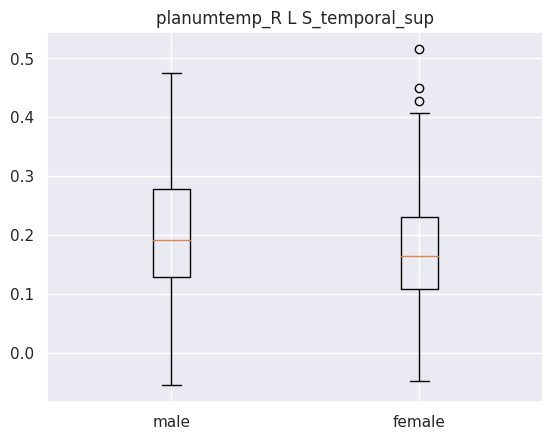

Ttest_indResult(statistic=3.6109779662087154, pvalue=0.00033203656606058823)
male mean : 0.20394091
male std : 0.10588711
female mean : 0.1741676
female std : 0.09061758
                                       Region       Men     Women   P value
0            pITG_R - L G_oc-temp_lat-fusifor  0.201700  0.179754  0.001111
1                      aMTG_R - L S_front_sup  0.099769  0.092938  0.189909
2                planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
3                      pITG_R - R S_front_inf  0.195457  0.174584  0.000361
4            aMTG_R - R G_cingul-Post-ventral  0.216054  0.195865  0.003669
5                   opIFG_R - R S_subparietal  0.016531 -0.012516  0.000006
6         aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146  0.537950
7                aMTG_R - R S_orbital_lateral -0.010003 -0.016049  0.372737
8  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651  0.002299
9             planumtemp_R - L S_temporal_sup  0.203941  0.174168  0.0

In [52]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

# Connectome

In [2]:
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")

In [3]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_dest["maps"])
label = atlas_dest["labels"].drop([0,42,117])
label = label.reset_index()
connectome_measure = ConnectivityMeasure(kind="correlation")



[get_dataset_dir] Dataset found in /home/cderoy/nilearn_data/destrieux_2009


In [5]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_no/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    # TODO le path des atlas a changer, à confirmer
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in Final_df["Subject"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

label_male = []
label_female = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["Subject"][i])

    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["Subject"][i])

## aMTG_R

In [6]:
label_male = []
label_female = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["Subject"][i])

    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["Subject"][i])
        

        
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)

# 959      0.016141        aMTG_R          L S_temporal_inf
# 453      0.015930        pITG_L   L G_cingul-Post-ventral
# 866      0.014635  planumtemp_R          R S_front_middle
# 598      0.014404       opIFG_R  L G_and_S_cingul-Mid-Ant
# 1014     0.014371        aMTG_R          R S_front_middle
# 900      0.012792        aMTG_R     L G_front_inf-Orbital
# 1012     0.012738        aMTG_R    R S_collat_transv_post
# 1002     0.012191        aMTG_R            R Lat_Fis-post
# 923      0.011730        aMTG_R   L G_temp_sup-Plan_tempo
# 983      0.011674        aMTG_R   R G_oc-temp_med-Lingual

print(label[label["name"] == "L S_temporal_inf"].index[0])
print(label[label["name"] == "R S_front_middle"].index[0])
print(label[label["name"] == "L G_front_inf-Orbital"].index[0])
print(label[label["name"] == "R S_collat_transv_post"].index[0])
print(label[label["name"] == "R Lat_Fis-post"].index[0])
print(label[label["name"] == "L G_temp_sup-Plan_tempo"].index[0])
print(label[label["name"] == "R G_oc-temp_med-Lingual"].index[0])

connectome_coord = np.array([coordinates[71], coordinates[126], coordinates[12], coordinates[124], coordinates[114], 
                             coordinates[35], coordinates[95]])

connectome_matrix_male = np.array([mean_correlation_male[71], mean_correlation_male[126], mean_correlation_male[12], mean_correlation_male[124],
                             mean_correlation_male[114], mean_correlation_male[35], mean_correlation_male[95]])

connectome_matrix_female = np.array([mean_correlation_female[71], mean_correlation_female[126], mean_correlation_female[12], mean_correlation_female[124],
                             mean_correlation_female[114], mean_correlation_female[35], mean_correlation_female[95]])
# 
# plotting.plot_connectome(connectome_matrix,
#                         connectome_coord,
#                         display_mode="ortho",
#                         edge_threshold="80%")
# plot_male = plotting.plot_markers(connectome_matrix_male, connectome_coord, node_cmap="seismic", display_mode="lyrz")
# plot_male.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size = 100)
# plot_female = plotting.plot_markers(connectome_matrix_female, connectome_coord, node_cmap="seismic", display_mode="lyrz")
# plot_female.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size=100)

71
126
12
124
114
35
95


In [7]:
mean_correlation_female[71]

0.09995291642942475

In [8]:
mean_correlation_male[71]

0.13605713355500001

## Connectome aMTG_R

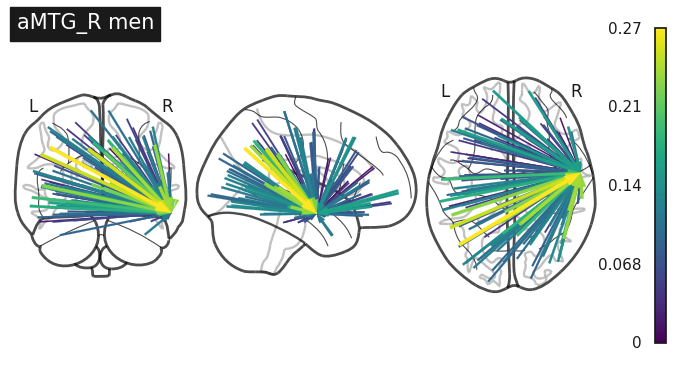

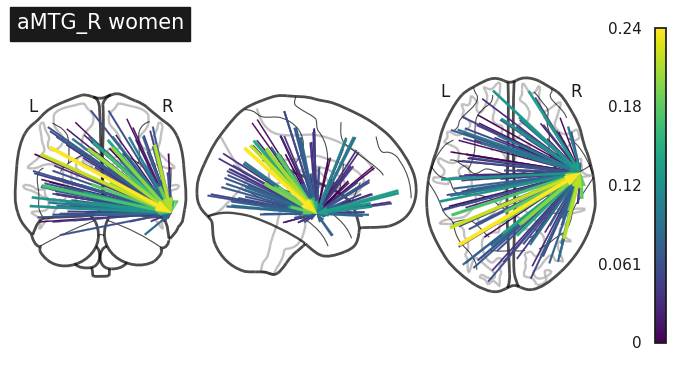

In [6]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_aMTG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_aMTG_male, 
                        np.insert(coordinates, 0, [60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_R men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/aMTG_R_Men_no.png",dpi=300)


correlation_matrix_aMTG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_aMTG_female, 
                        np.insert(coordinates, 0, [60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_R women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/aMTG_R_Women_no.png",dpi=300)

## Connectome aMTG_L

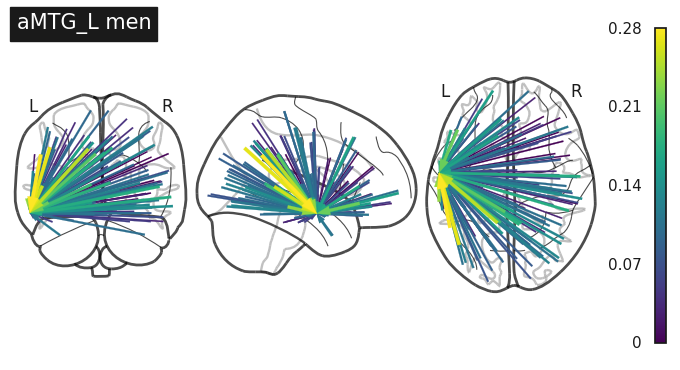

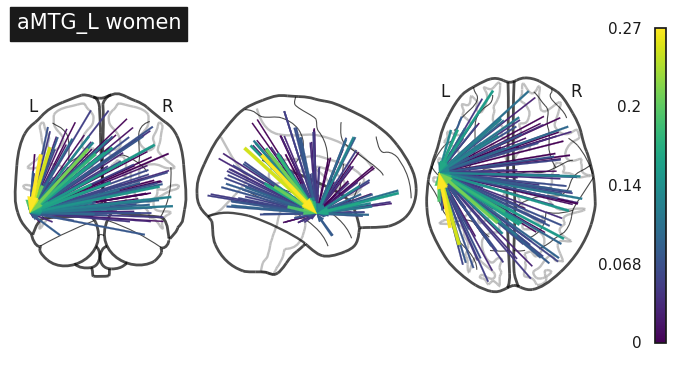

In [7]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_aMTG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_aMTG_male, 
                        np.insert(coordinates, 0, [-60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_L men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/aMTG_L_Men_no.png",dpi=300)

correlation_matrix_aMTG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_aMTG_female, 
                        np.insert(coordinates, 0, [-60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_L women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/aMTG_L_Women_no.png",dpi=300)

## opIFG_L 

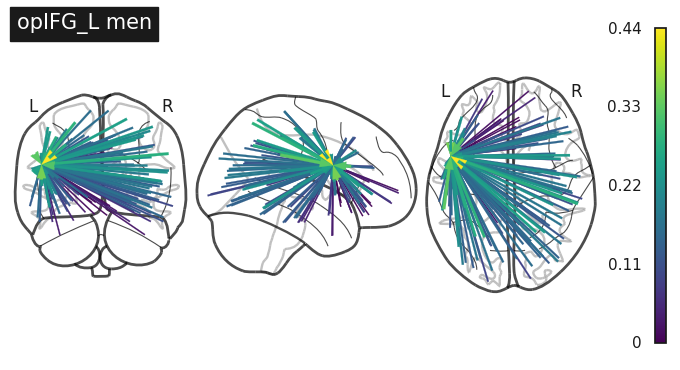

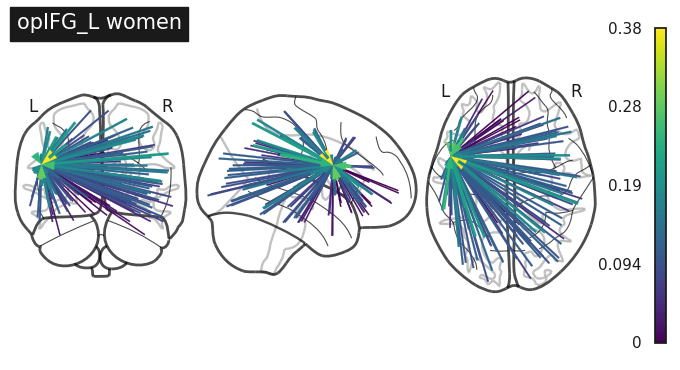

In [8]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "opIFG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "opIFG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_opIFG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_opIFG_male, 
                        np.insert(coordinates, 0, [-50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_L men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/opIFG_L_Men_no.png", dpi= 300)


correlation_matrix_opIFG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_opIFG_female, 
                        np.insert(coordinates, 0, [-50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_L women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/opIFG_L_Women_no.png",dpi=300)

# opIFG_R

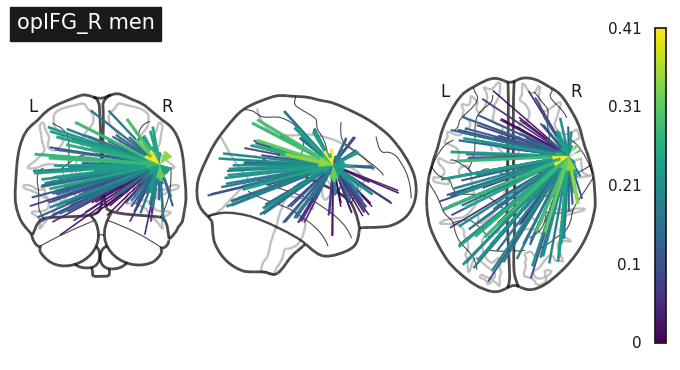

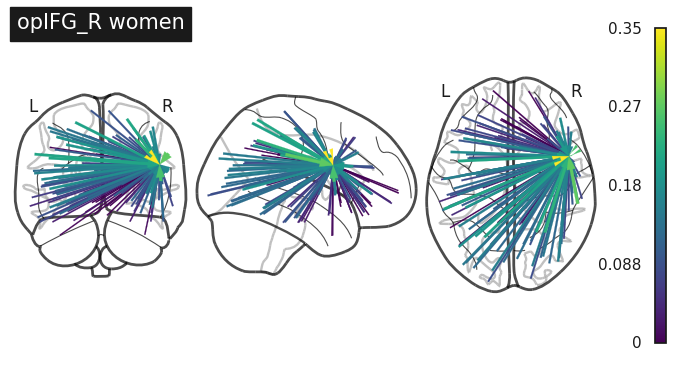

In [9]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "opIFG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "opIFG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_opIFG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_opIFG_male, 
                        np.insert(coordinates, 0, [50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_R men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/opIFG_R_Men_no.png",dpi=300)


correlation_matrix_opIFG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_opIFG_female, 
                        np.insert(coordinates, 0, [50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_R women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/opIFG_R_Women_no.png",dpi=300)

# pITG_L

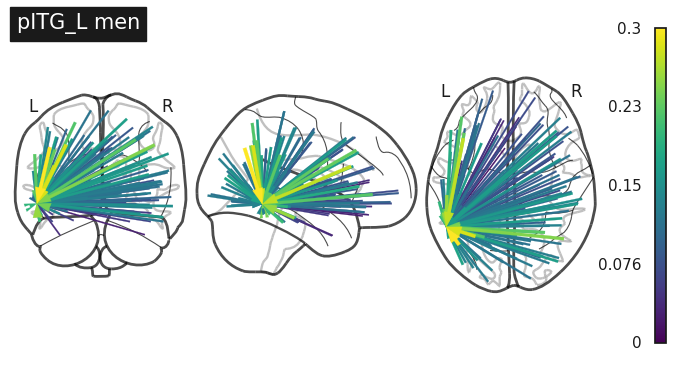

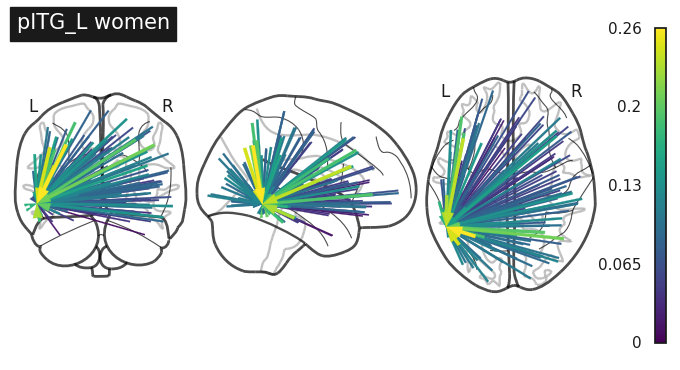

In [10]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "pITG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "pITG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_pITG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men =plotting.plot_connectome(correlation_matrix_pITG_male, 
                        np.insert(coordinates, 0, [-54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_L men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/pITG_L_Men_no.png",dpi=300)

correlation_matrix_pITG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_pITG_female, 
                        np.insert(coordinates, 0, [-54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_L women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/pITG_L_Women_no.png",dpi=300)

# pITG_R

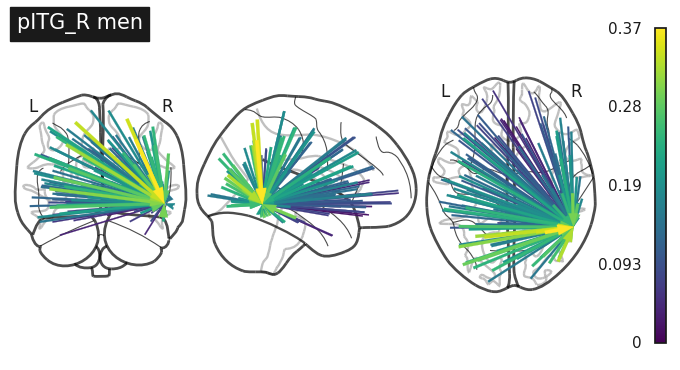

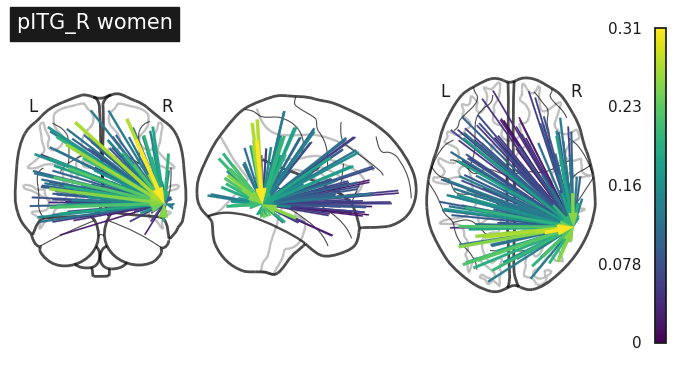

In [11]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "pITG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "pITG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_pITG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_pITG_male, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_R men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/pITG_R_Men_no.png",dpi=300)

correlation_matrix_pITG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_pITG_female, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_R women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/pITG_R_Women_no.png",dpi=300)

# planumtemp_L

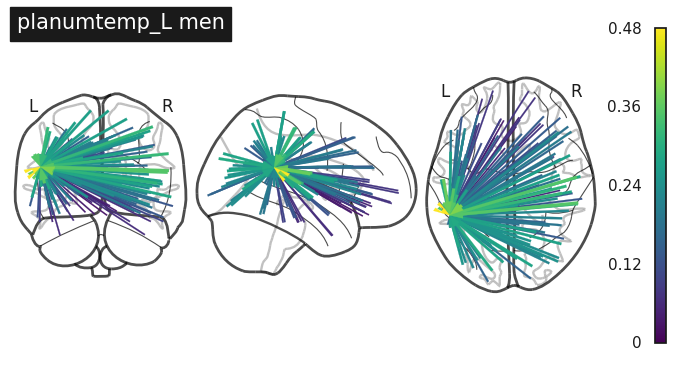

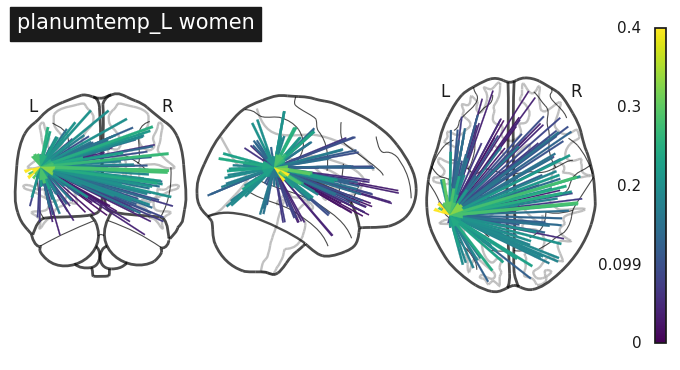

In [12]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "planumtemp_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "planumtemp_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_planumtemp_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_planumtemp_male, 
                        np.insert(coordinates, 0, [-51, -42, 21], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_L men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/planumtemp_L_Men_no.png",dpi=300)

correlation_matrix_planumtemp_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_planumtemp_female, 
                        np.insert(coordinates, 0, [-51, -42, 21], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_L women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/planumtemp_L_Women_no.png",dpi=300)

# planumtemp_R

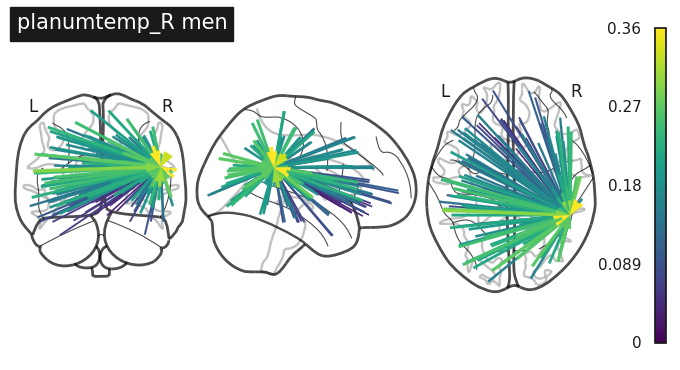

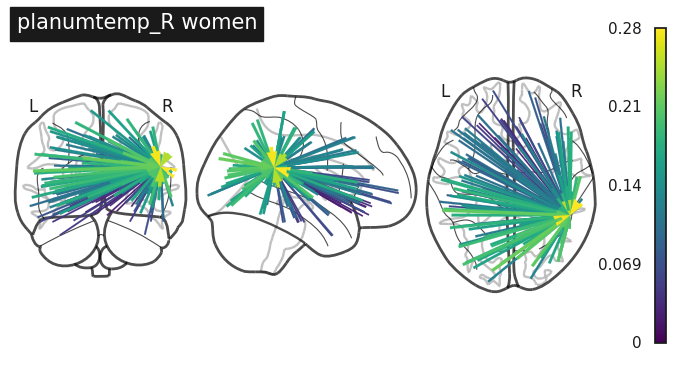

In [13]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "planumtemp_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "planumtemp_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_planumtemp_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_planumtemp_male, 
                        np.insert(coordinates, 0, [51, -42, 21], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_R men",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_men.savefig("./Images/planumtemp_R_Men_no.png",dpi=300)

correlation_matrix_planumtemp_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_planumtemp_female, 
                        np.insert(coordinates, 0, [51, -42, 21], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_R women",
                        edge_kwargs={"linewidth":0.15},
                        edge_cmap="viridis")
fig_women.savefig("./Images/planumtemp_R_Women_no.png",dpi=300)

# Correlation between resting state

In [96]:
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl_REST1LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST1RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1RL_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST2LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"

Final_df["subject_label"]
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

for seed in SEEDS:
    corr_1LR_1RL = []
    corr_1LR_2LR = []
    corr_1LR_2RL = []
    corr_1RL_2LR = []
    corr_1RL_2RL = []
    corr_2LR_2RL = []
    rest1LR = []
    rest1RL = []
    rest2LR = []
    rest2RL = []
    
    rest1LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest1RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
        
    for j in range(0, len(rest1LR[0])):
        corr_1LR_1RL.append(np.corrcoef(rest1LR[0][j], rest1RL[0][j])[0][1])
        corr_1LR_2LR.append(np.corrcoef(rest1LR[0][j], rest2LR[0][j])[0][1])
        corr_1LR_2RL.append(np.corrcoef(rest1LR[0][j], rest2RL[0][j])[0][1])
        corr_1RL_2LR.append(np.corrcoef(rest1RL[0][j], rest2LR[0][j])[0][1])
        corr_1RL_2RL.append(np.corrcoef(rest1RL[0][j], rest2RL[0][j])[0][1])
        corr_2LR_2RL.append(np.corrcoef(rest2LR[0][j], rest2RL[0][j])[0][1])
        
        
    print(seed)
    print("rest1LR and rest1RL")
    print("mean : " + str(np.mean(corr_1LR_1RL)))
    print("min : " + str(min(corr_1LR_1RL)))
    print("max : " + str(max(corr_1LR_1RL)))
    print("\n")
    print("rest1LR and rest2LR")
    print("mean : " + str(np.mean(corr_1LR_2LR)))
    print("min : " + str(min(corr_1LR_2LR)))
    print("max : " + str(max(corr_1LR_2LR)))
    print("\n")
    print("rest1LR and rest2RL")
    print("mean : " + str(np.mean(corr_1LR_2RL)))
    print("min : " + str(min(corr_1LR_2RL)))
    print("max : " + str(max(corr_1LR_2RL)))
    print("\n")
    print("rest1RL and rest2LR")
    print("mean : " + str(np.mean(corr_1RL_2LR)))
    print("min : " + str(min(corr_1RL_2LR)))
    print("max : " + str(max(corr_1RL_2LR)))
    print("\n")
    print("rest1RL and rest2RL")
    print("mean : " + str(np.mean(corr_1RL_2RL)))
    print("min : " + str(min(corr_1RL_2RL)))
    print("max : " + str(max(corr_1RL_2RL)))
    print("\n")
    print("rest2LR and rest2RL")
    print("mean : " + str(np.mean(corr_2LR_2RL)))
    print("min : " + str(min(corr_2LR_2RL)))
    print("max : " + str(max(corr_2LR_2RL)))
    print("\n")
    print("\n")

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


opIFG_L
rest1LR and rest1RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest1LR and rest2LR
mean : 0.7698490941301699
min : 0.1018440521993477
max : 0.9586093500051478


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7750584728732756
min : 0.05147001936993981
max : 0.9511524080813849


rest1RL and rest2RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest2LR and rest2RL
mean : 0.7698490941301698
min : 0.10184405219934768
max : 0.9586093500051476




planumtemp_L
rest1LR and rest1RL
mean : 0.7885160499127559
min : 0.11528407305428233
max : 0.9650591348987411


rest1LR and rest2LR
mean : 0.7693670776944767
min : 0.12378670509244566
max : 0.970730776939474


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7611741204293923
min : 0.05853655064429218
max : 0.9535431025556377


rest1RL and rest2RL
mean : 0.7885160499127559
min :